In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report  
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_log_error

In [2]:
df = pd.read_csv('data/train.csv', index_col=0, parse_dates=True)

In [3]:
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  count       10886 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 1020.6 KB


In [5]:
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [6]:
df.isnull().values.any()

False

In [7]:
df.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

### Transform the Count variable: 
* We use a logarithmic transformation to optimize the target's distribution. Idealy we want a normal distribution for linear models.

* In this way we also make sure we do not predict negative counts

<AxesSubplot:xlabel='count', ylabel='Count'>

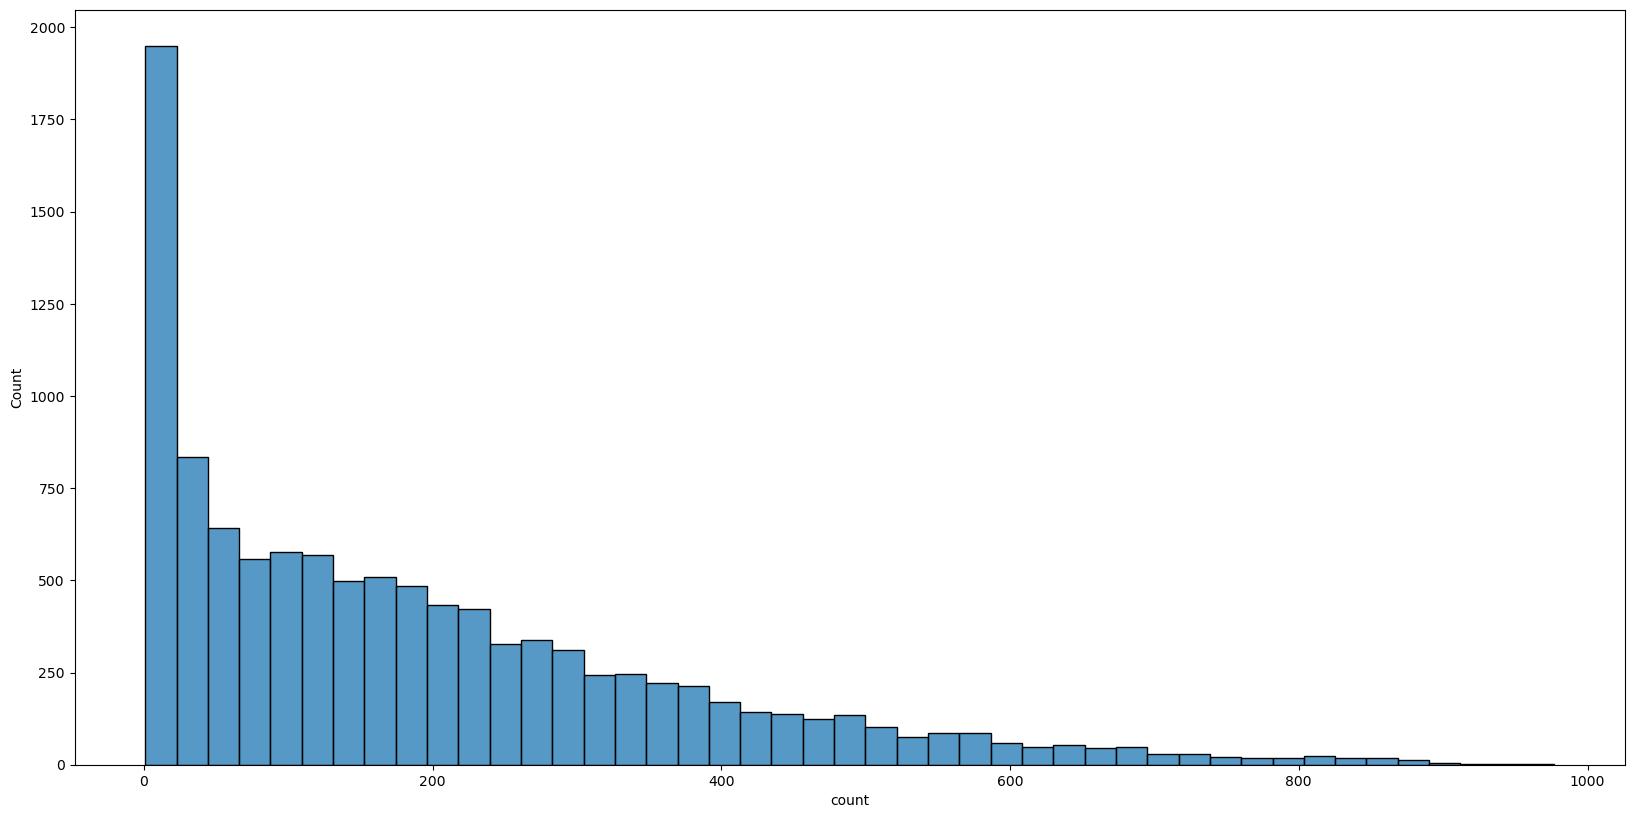

In [8]:
plt.figure(figsize=(20,10),dpi=100)
sns.histplot(data=df, x='count')


In [9]:
# We need to transorm our lables because their distribution is not normal:
df['count'] = np.log1p(df['count'])

<AxesSubplot:xlabel='count', ylabel='Count'>

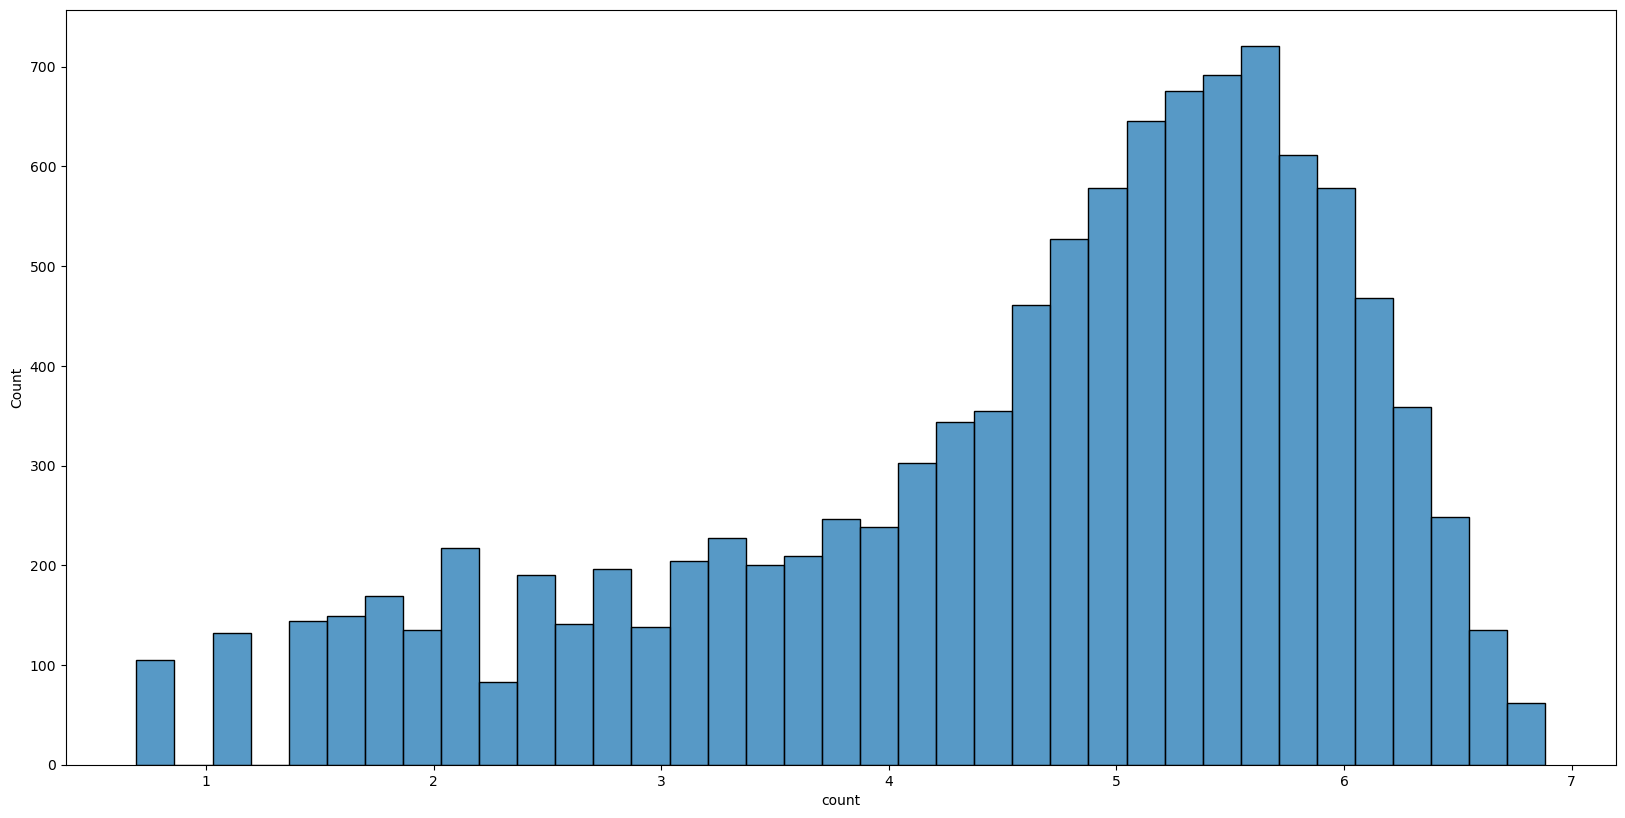

In [10]:
plt.figure(figsize=(20,10),dpi=100)
sns.histplot(data=df, x='count')

In [11]:
# Create datetime columns
df['hour'] = df.index.hour
df['day'] = df.index.day
df['weekday'] = df.index.weekday
df['month'] = df.index.month
df['year'] = df.index.year
df.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'casual', 'registered', 'count', 'hour', 'day',
       'weekday', 'month', 'year'],
      dtype='object')

## Check correlation between numerical features

In [12]:
df[['temp', 'atemp', 'humidity', 'windspeed', 'count']].corr()

,temp,atemp,humidity,windspeed,count
temp,1.000000,0.984948,-0.064949,-0.017852,0.376587
atemp,0.984948,1.000000,-0.043536,-0.057473,0.372167
humidity,-0.064949,-0.043536,1.000000,-0.318607,-0.333158
windspeed,-0.017852,-0.057473,-0.318607,1.000000,0.122754
count,0.376587,0.372167,-0.333158,0.122754,1.000000


Text(0.5, 1.0, 'Pairwise Correlation')

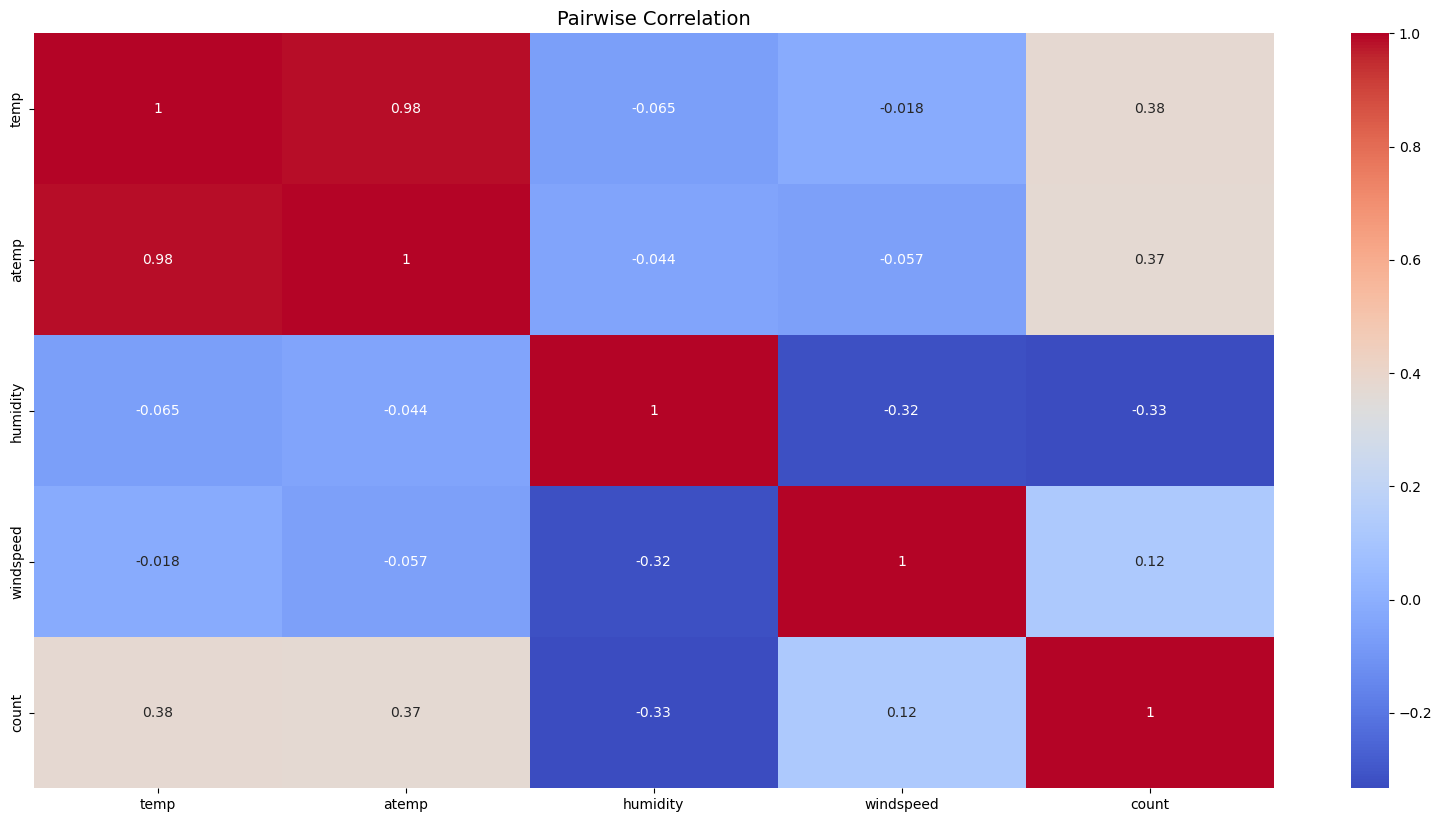

In [13]:
plt.figure(figsize=(20,10),dpi=100)
sns.heatmap(df[['temp', 'atemp', 'humidity', 'windspeed', 'count']].corr(),cmap='coolwarm',annot=True)
plt.title('Pairwise Correlation', fontsize=14)

### Conclusions
* Temp and atemp (real feel) are high correlated, so no need to keep both. Temperature seems a tiny bit more correlated with counts so atemp can be dropded.
* Windspeed has the lower correlation with counts.

## How Weather conditions affect counts

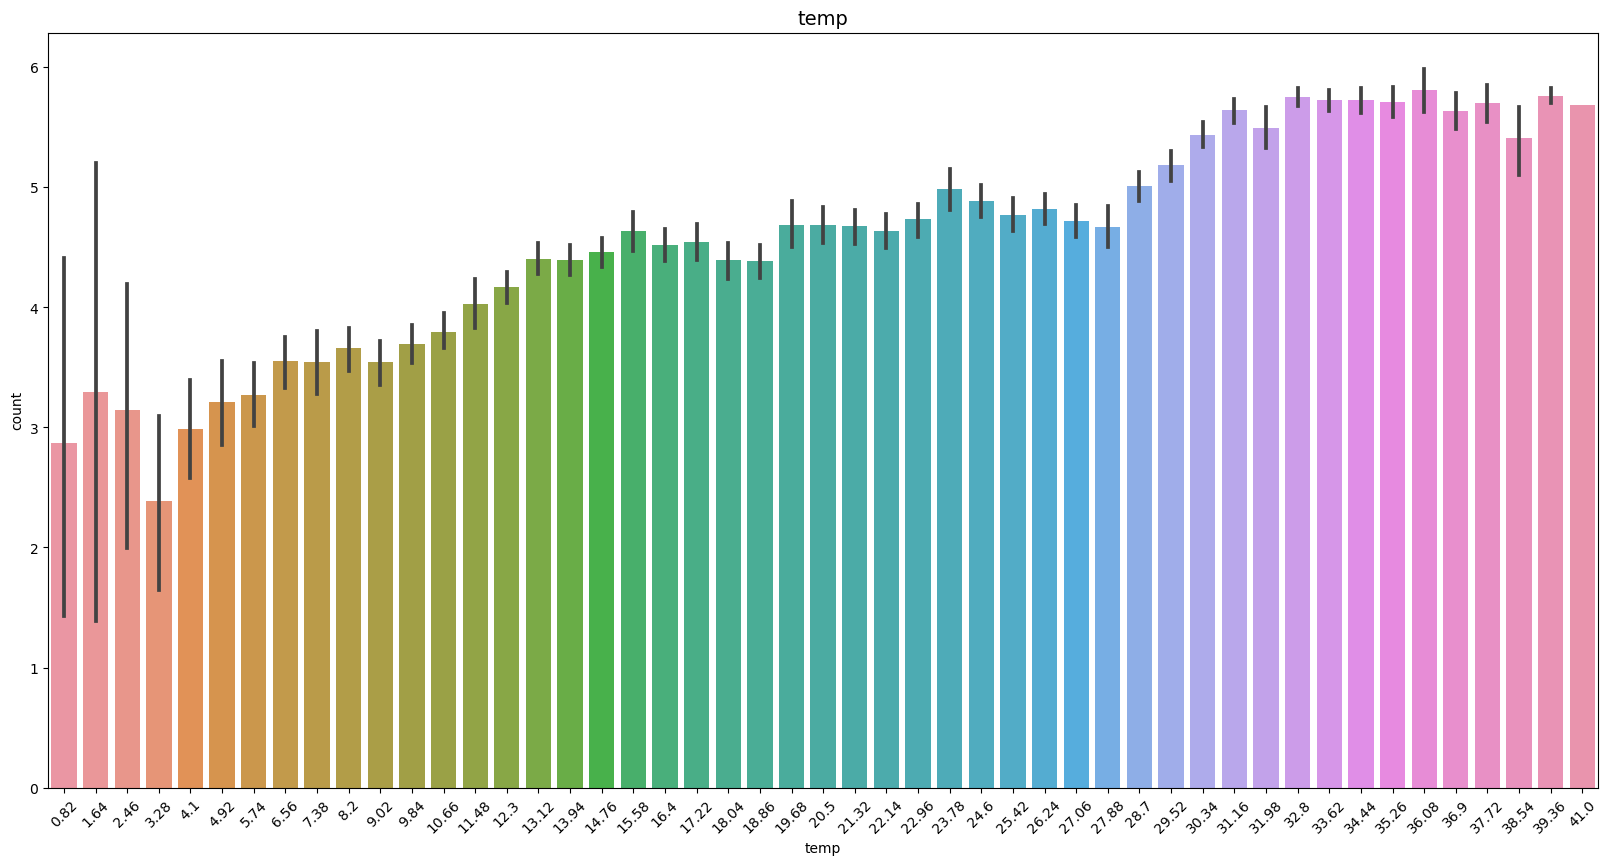

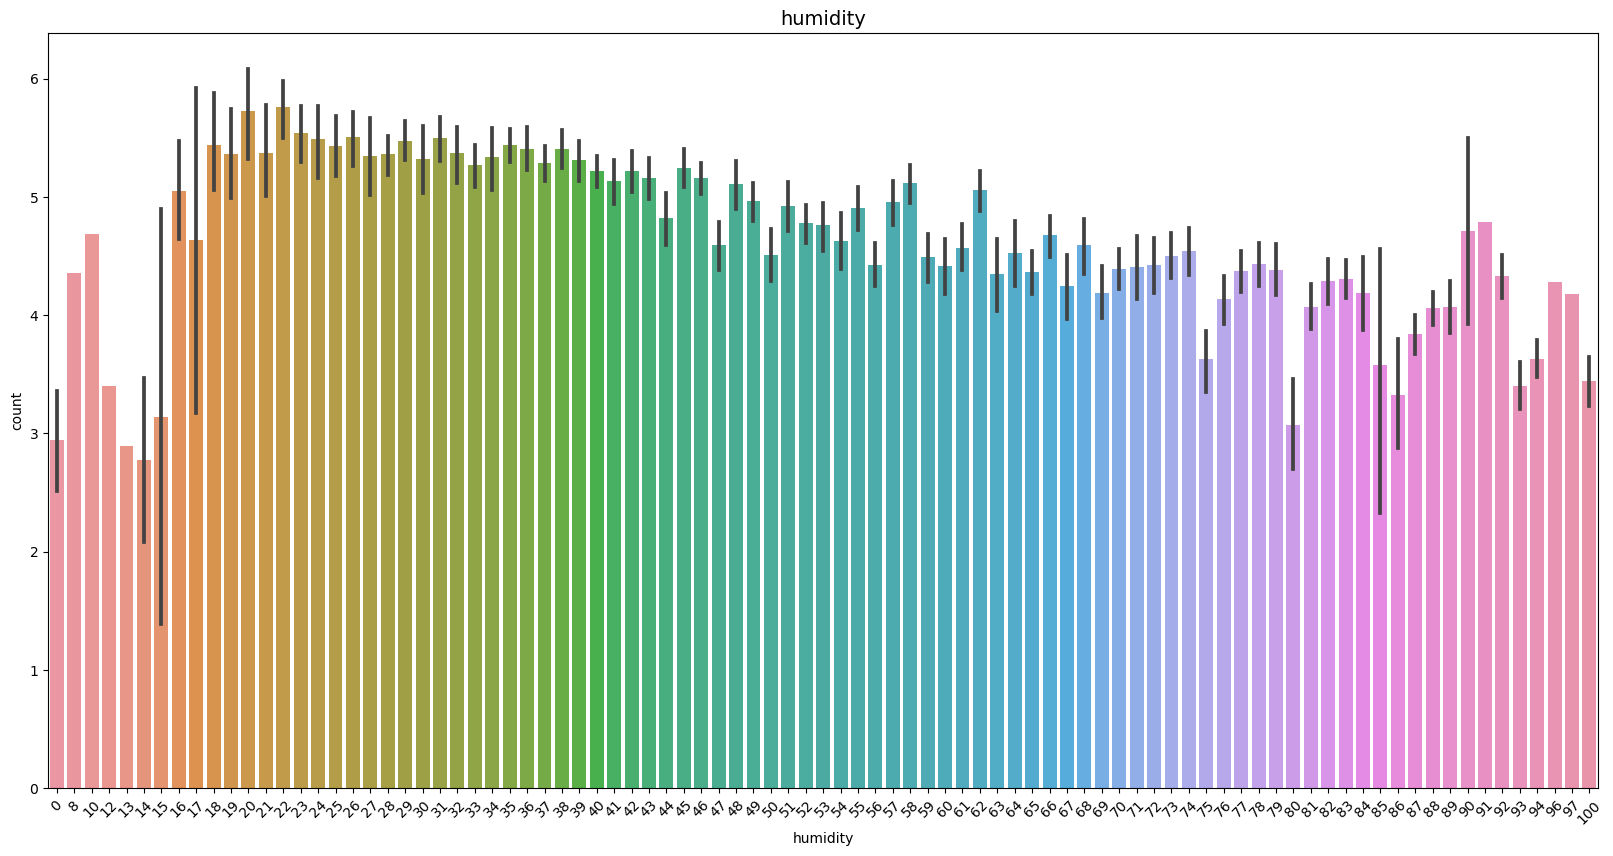

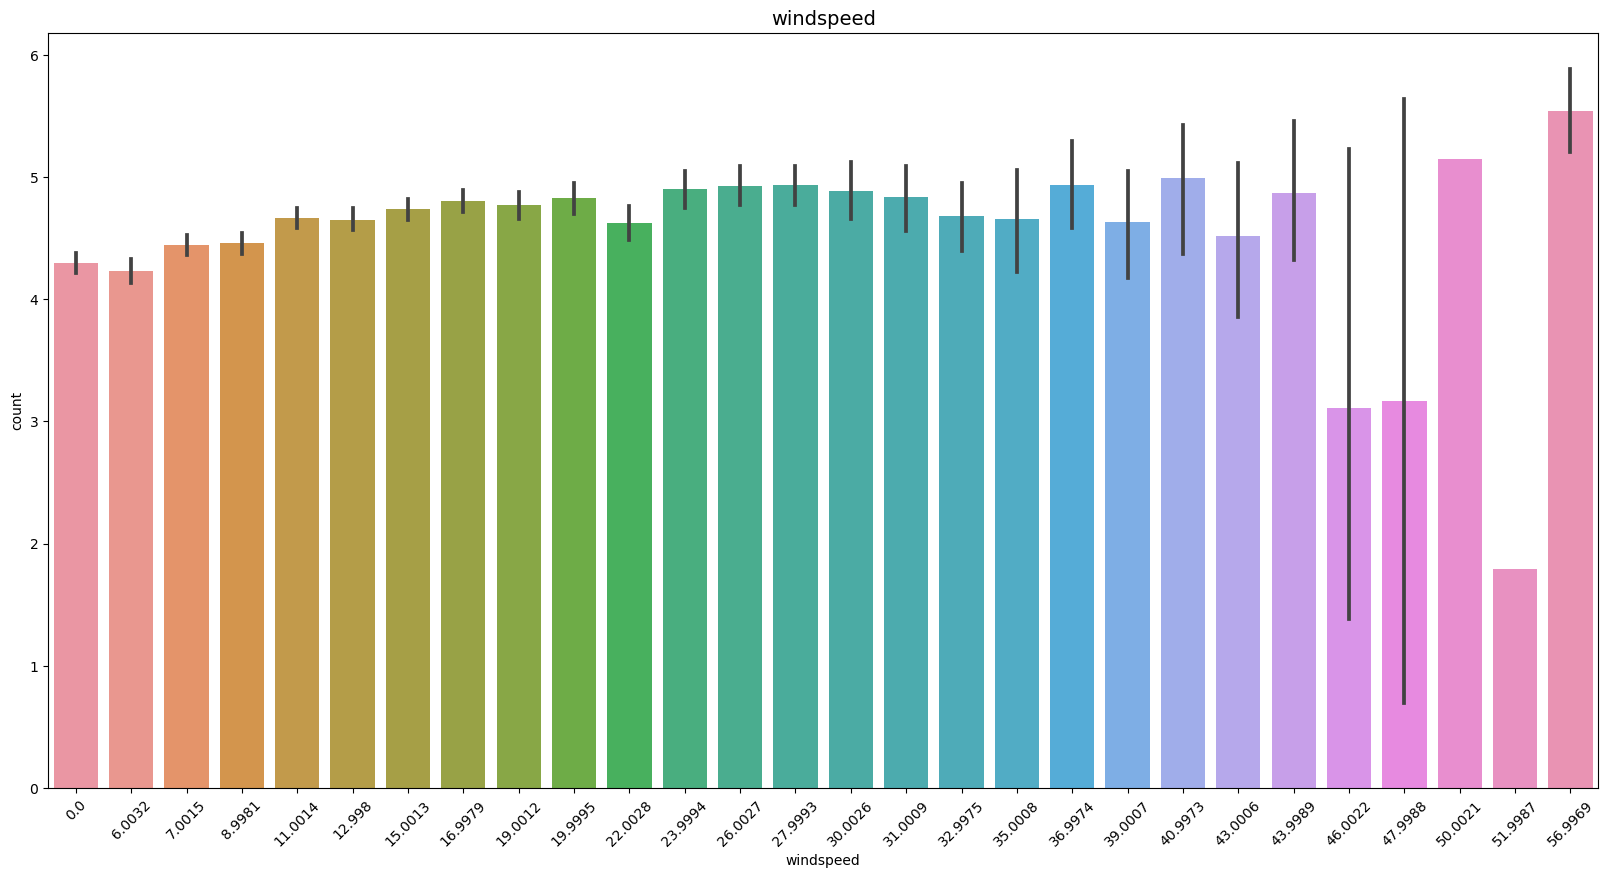

In [14]:
for column in ['temp', 'humidity', 'windspeed']:
    plt.figure(figsize=(20,10),dpi=100)
    sns.barplot(data = df,x=column,y='count')
    plt.title(f'{column}', fontsize=14)
    plt.xticks(rotation=45)
    plt.show()

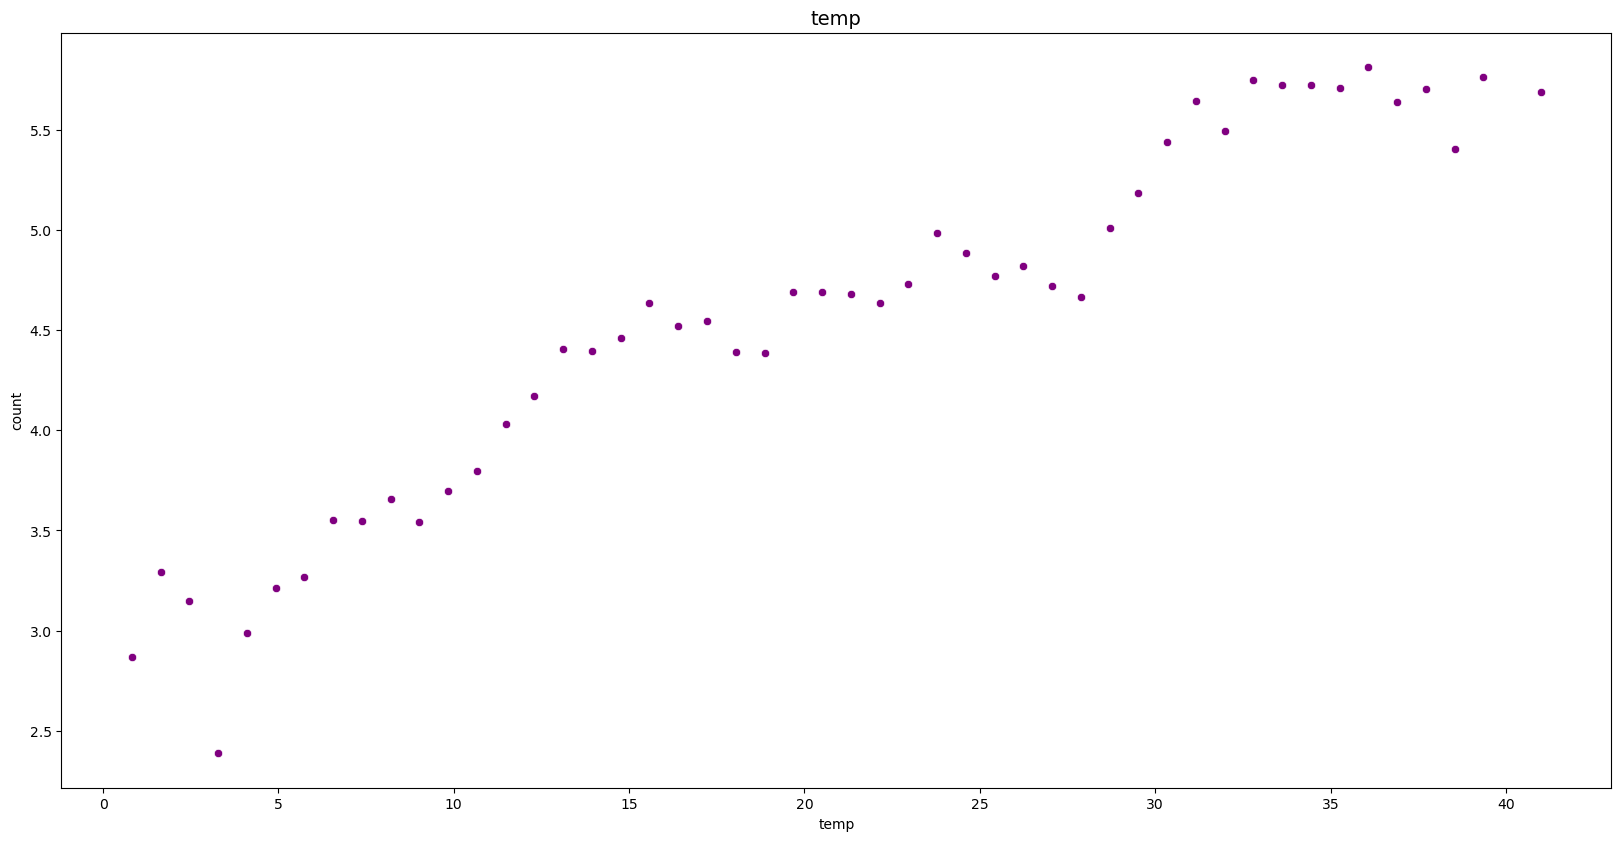

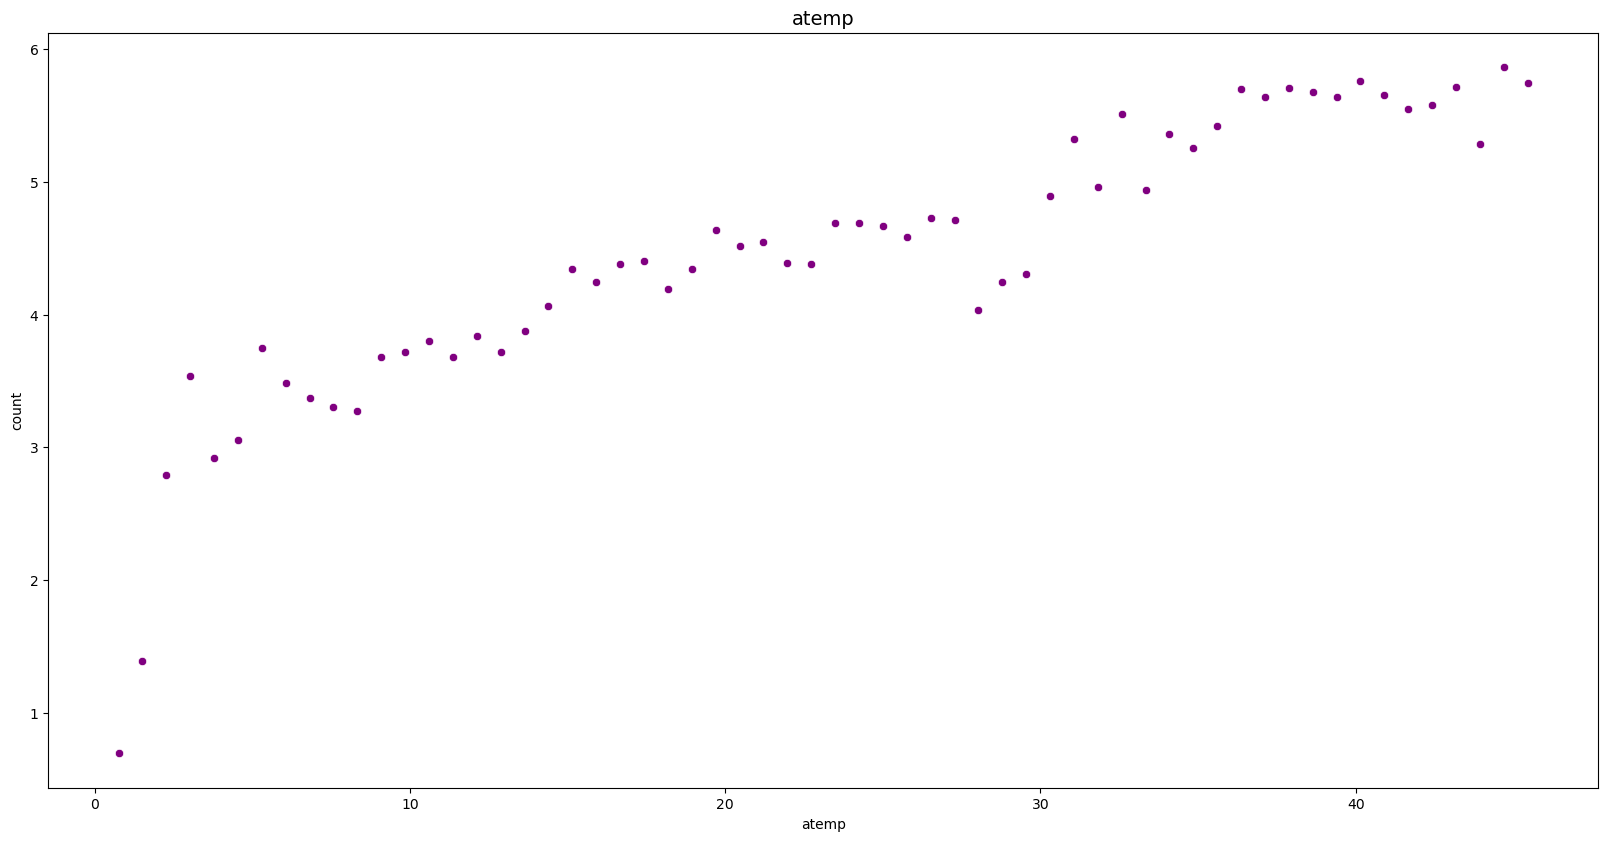

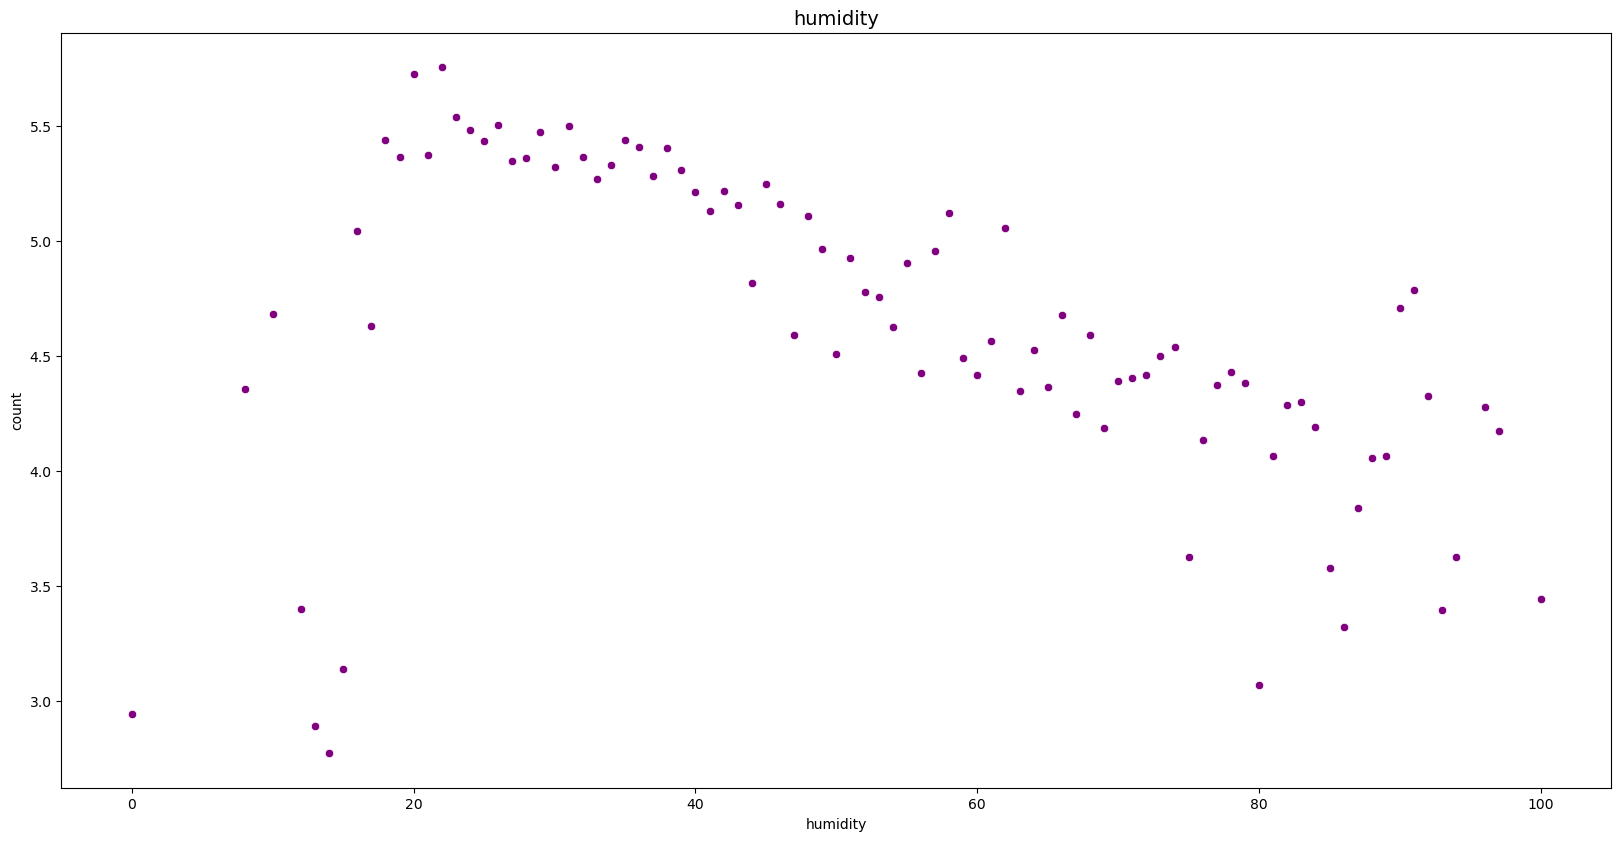

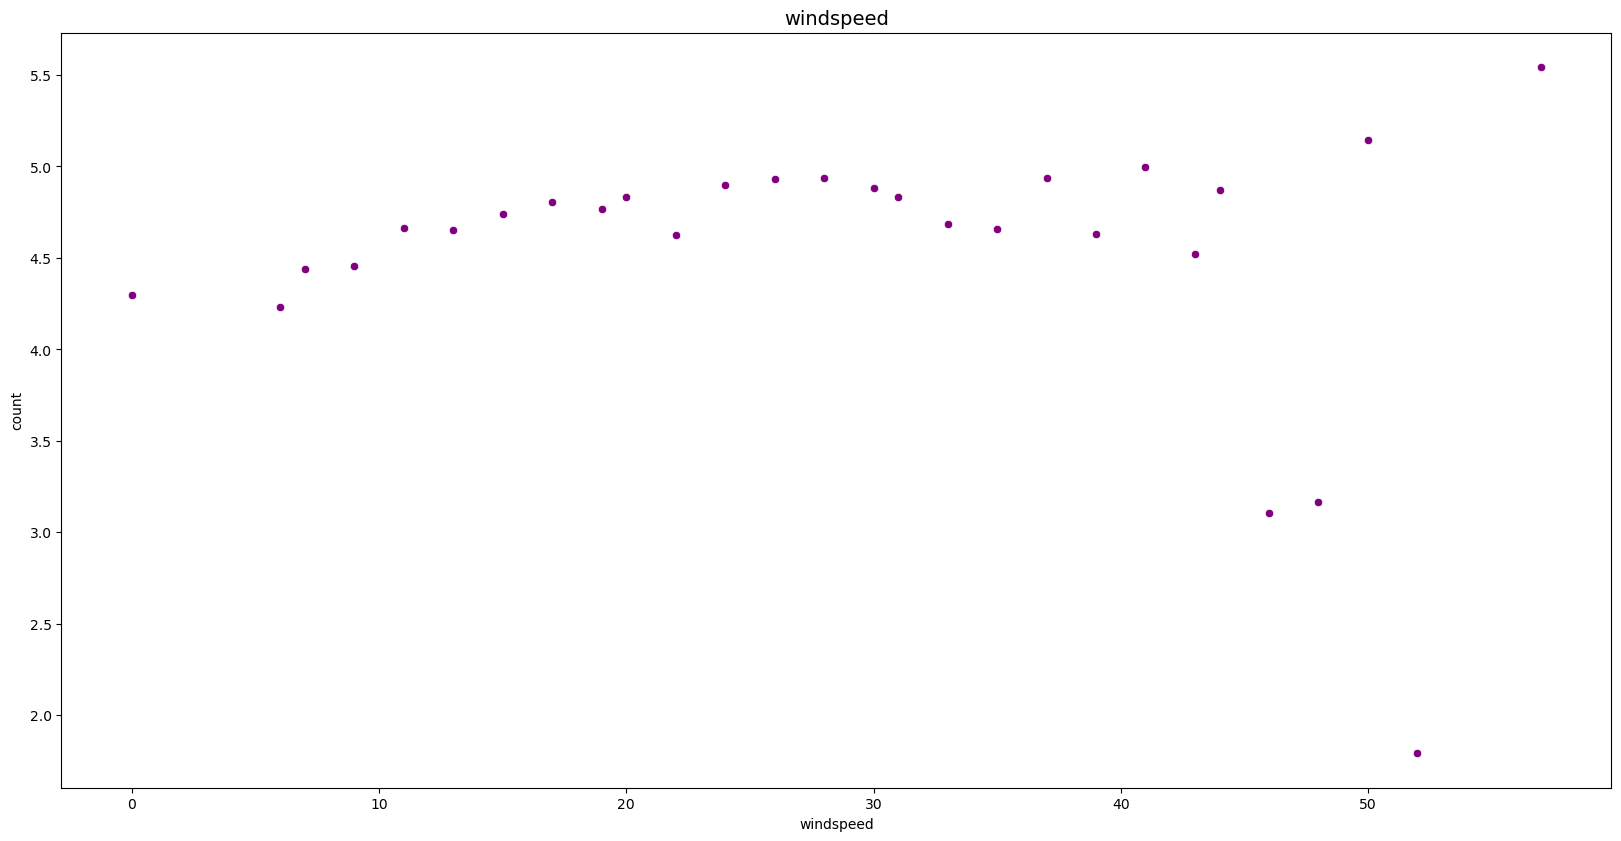

In [15]:
for column in ['temp', 'atemp', 'humidity', 'windspeed']:
    plt.figure(figsize=(20,10),dpi=100)
    sns.scatterplot(data = df.groupby(column).mean(),x=column,y='count', color="purple")
    plt.title(f'{column}', fontsize=14)
    plt.show()

### Conlusions 
#### Temperature and real feel temperature
* Counts are low for low temperatures, increase as temperature increases. The scatter plots show a close to linear behavour, although there seems to be a plateau above 30.
#### Windspeed 
* Windspeed does not seem to affect that much the mean count. Correlation is also relattivly low (0.1 as can be seen from table above)
#### Humidity
* There is a clear drop as humitidy increases. For very low humitidy counts drop again but the "observarions" we have with low humidity are very few. Two possibilities to be investigated:
    - Too low humidity can drop real feel of temperature (https://science.howstuffworks.com/nature/climate-weather/atmospheric/question651.htm). 
    - Low counts are due to other condtitions, eg: hour of the day

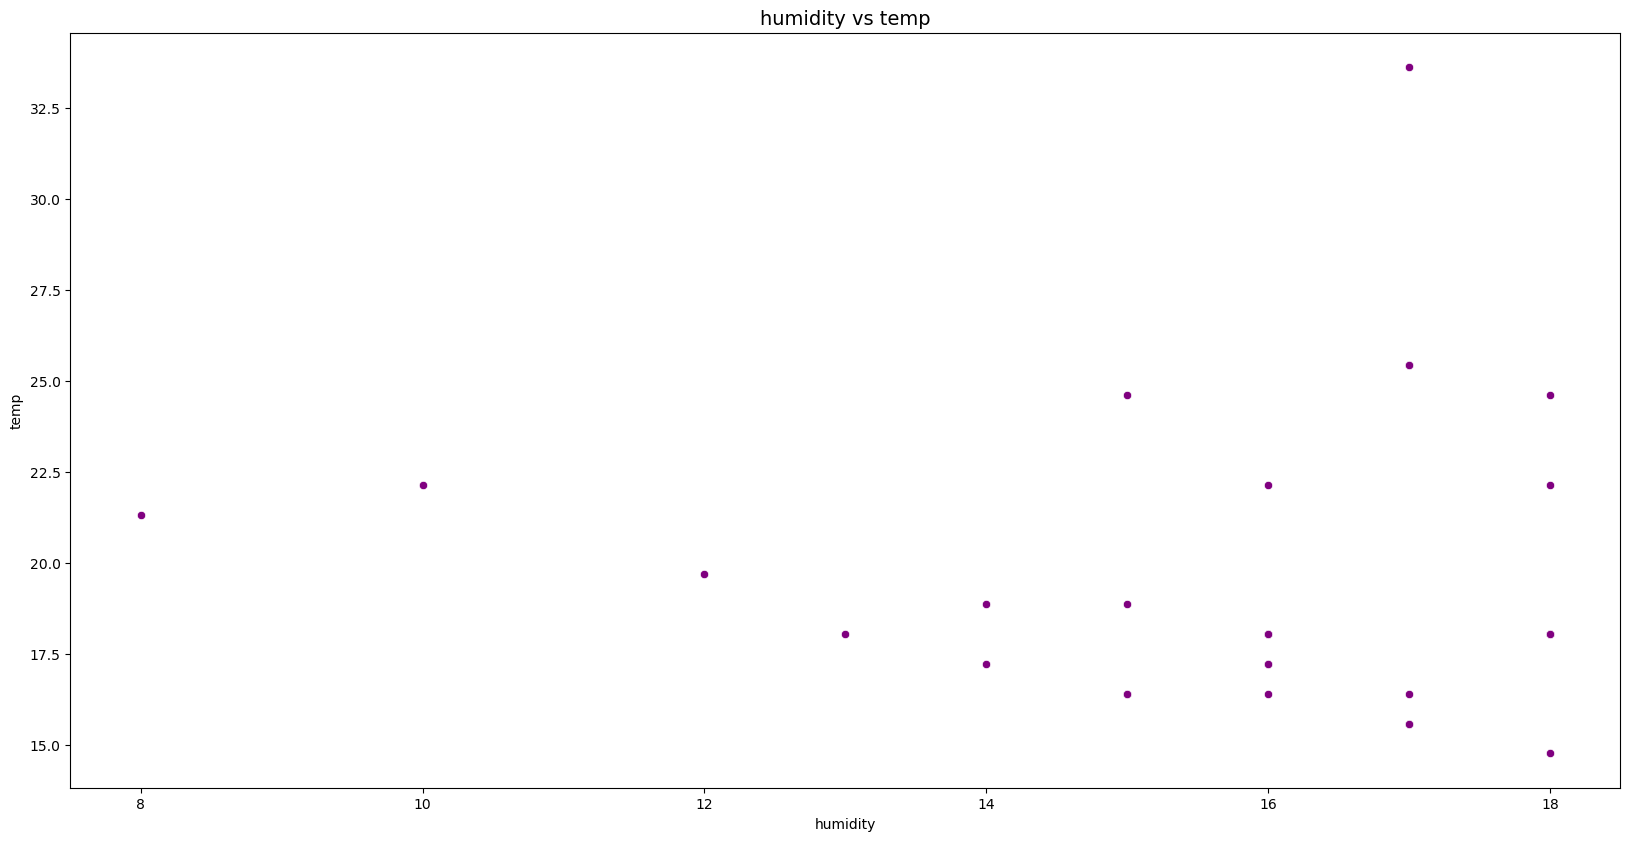

In [59]:
plt.figure(figsize=(20,10),dpi=100)
sns.scatterplot(data = df[df['humidity']<=18],x='humidity',y='temp', color="purple")
plt.title(f'humidity vs temp', fontsize=14)
plt.show()

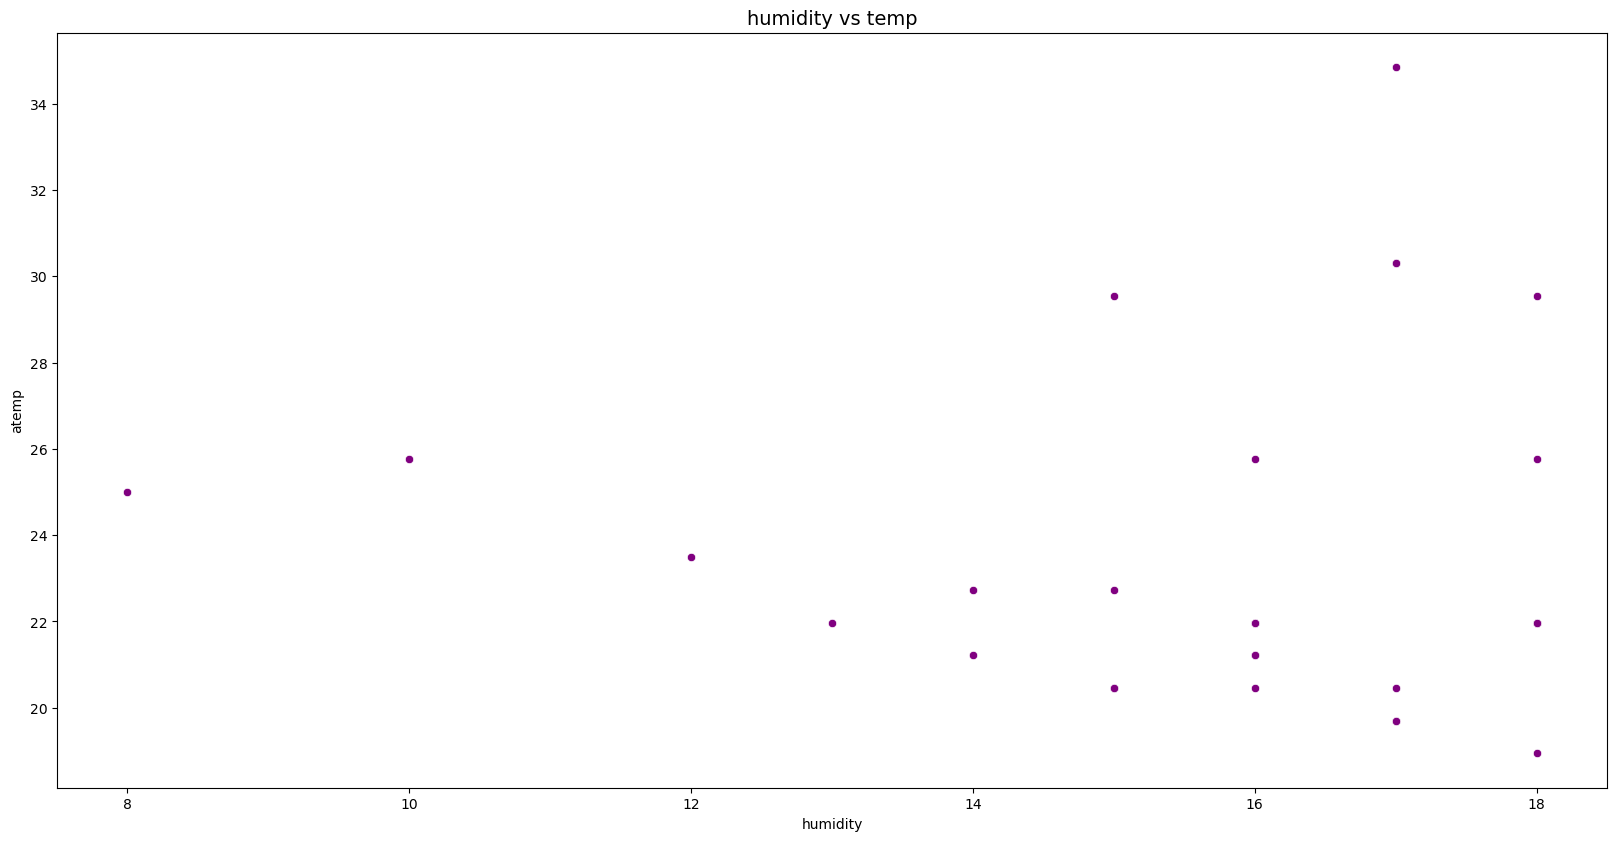

In [60]:
plt.figure(figsize=(20,10),dpi=100)
sns.scatterplot(data = df[df['humidity']<=18],x='humidity',y='atemp', color="purple")
plt.title(f'humidity vs temp', fontsize=14)
plt.show()

Temperature and and real feel does not apear to differ significantly for low humidity. Thus hypothesis no1 does not seem to hold.

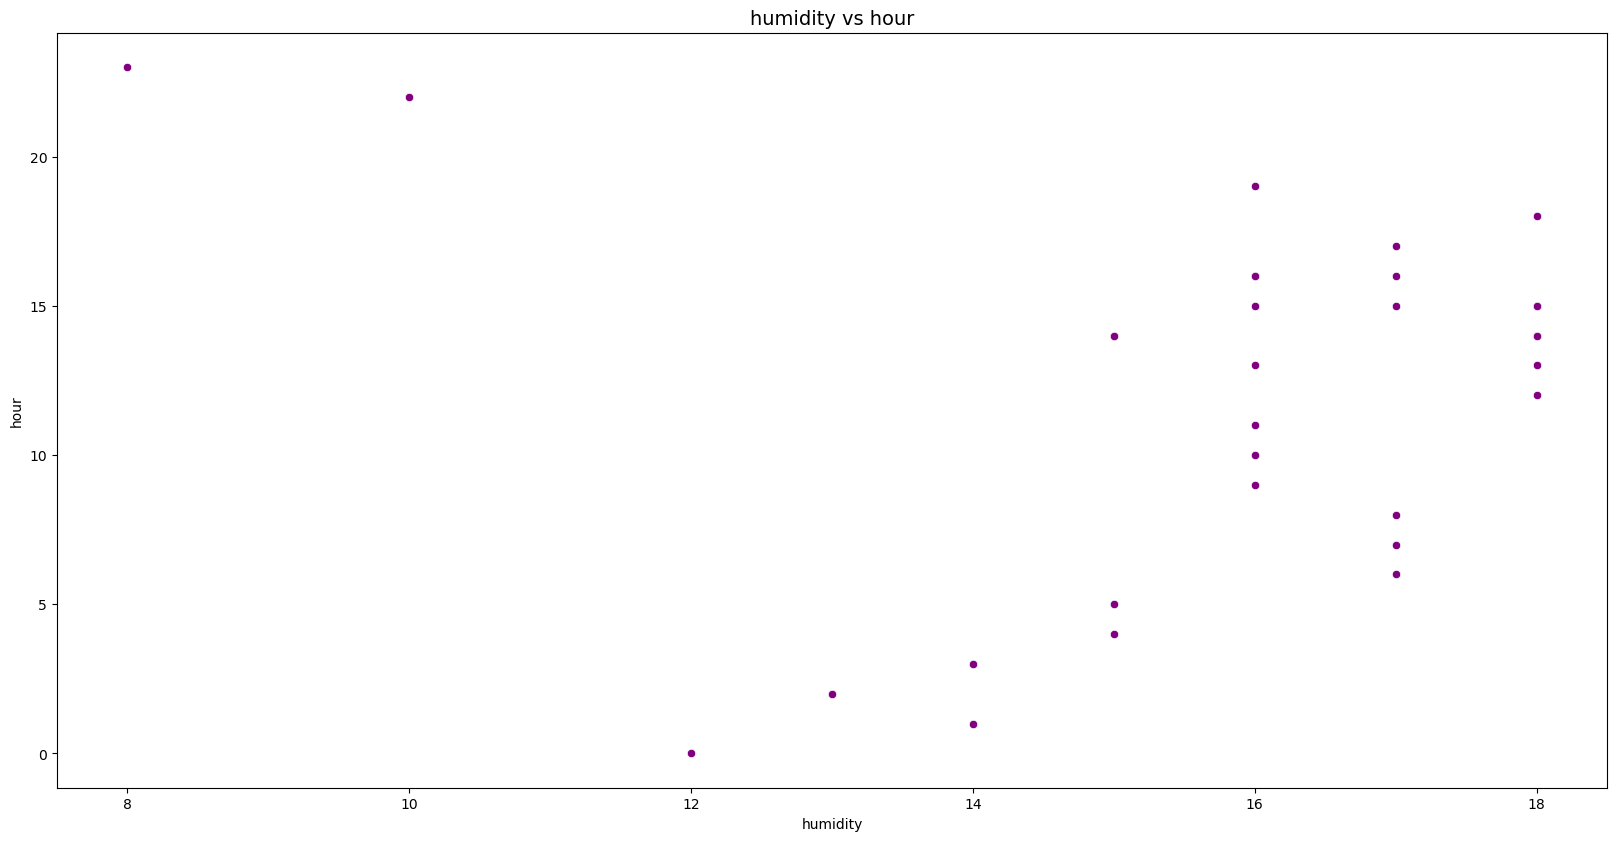

In [63]:
plt.figure(figsize=(20,10),dpi=100)
sns.scatterplot(data = df[df['humidity']<=18],x='humidity',y='hour', color="purple")
plt.title(f'humidity vs hour', fontsize=14)
plt.show()

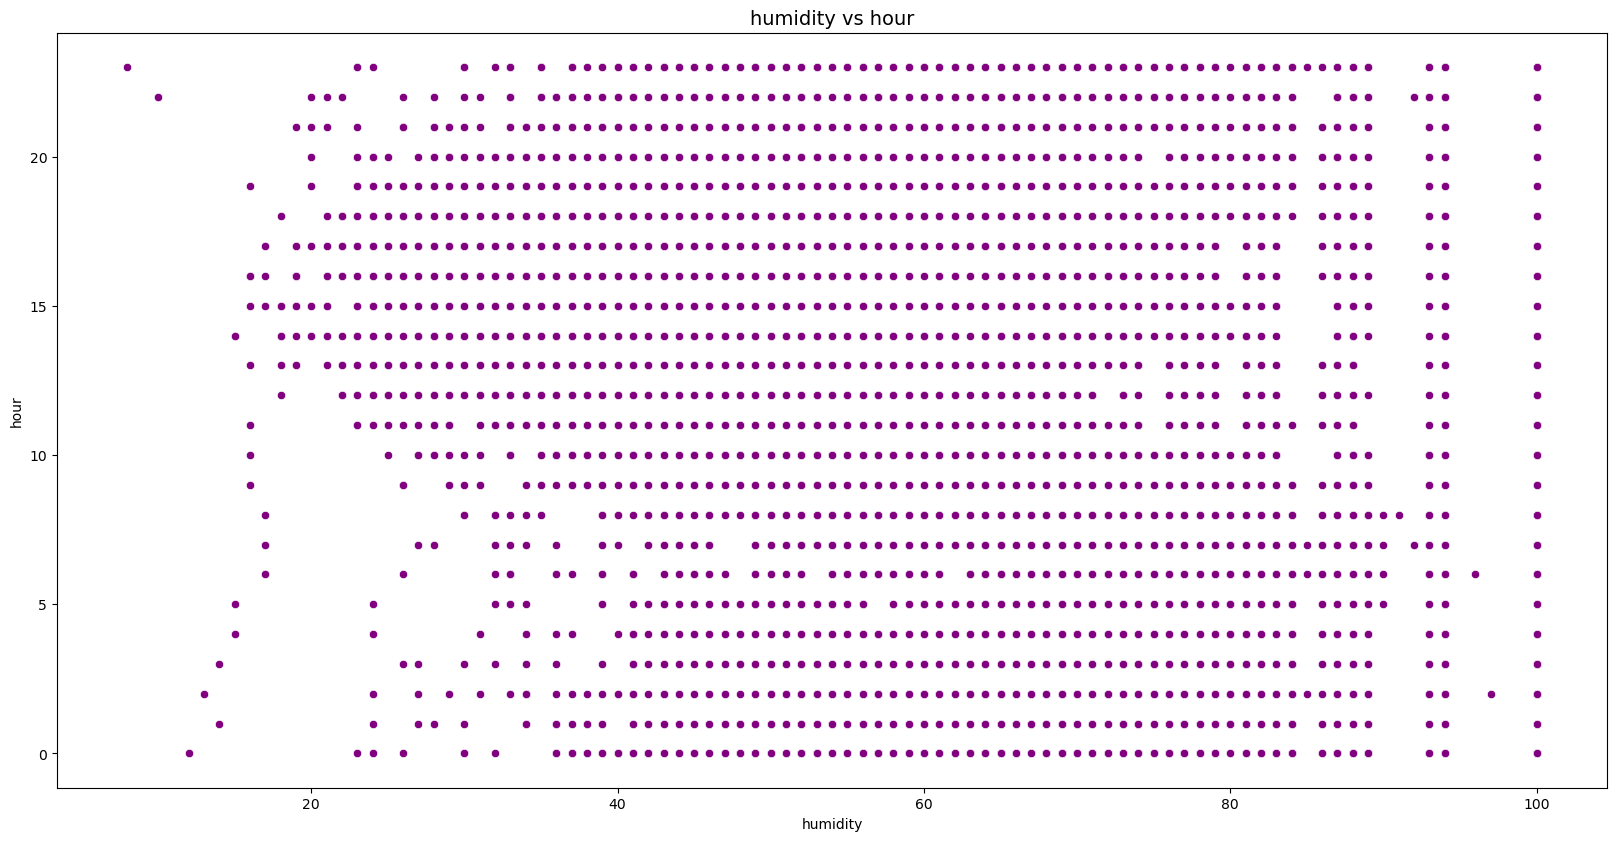

In [62]:
plt.figure(figsize=(20,10),dpi=100)
sns.scatterplot(data = df,x='humidity',y='hour', color="purple")
plt.title(f'humidity vs hour', fontsize=14)
plt.show()

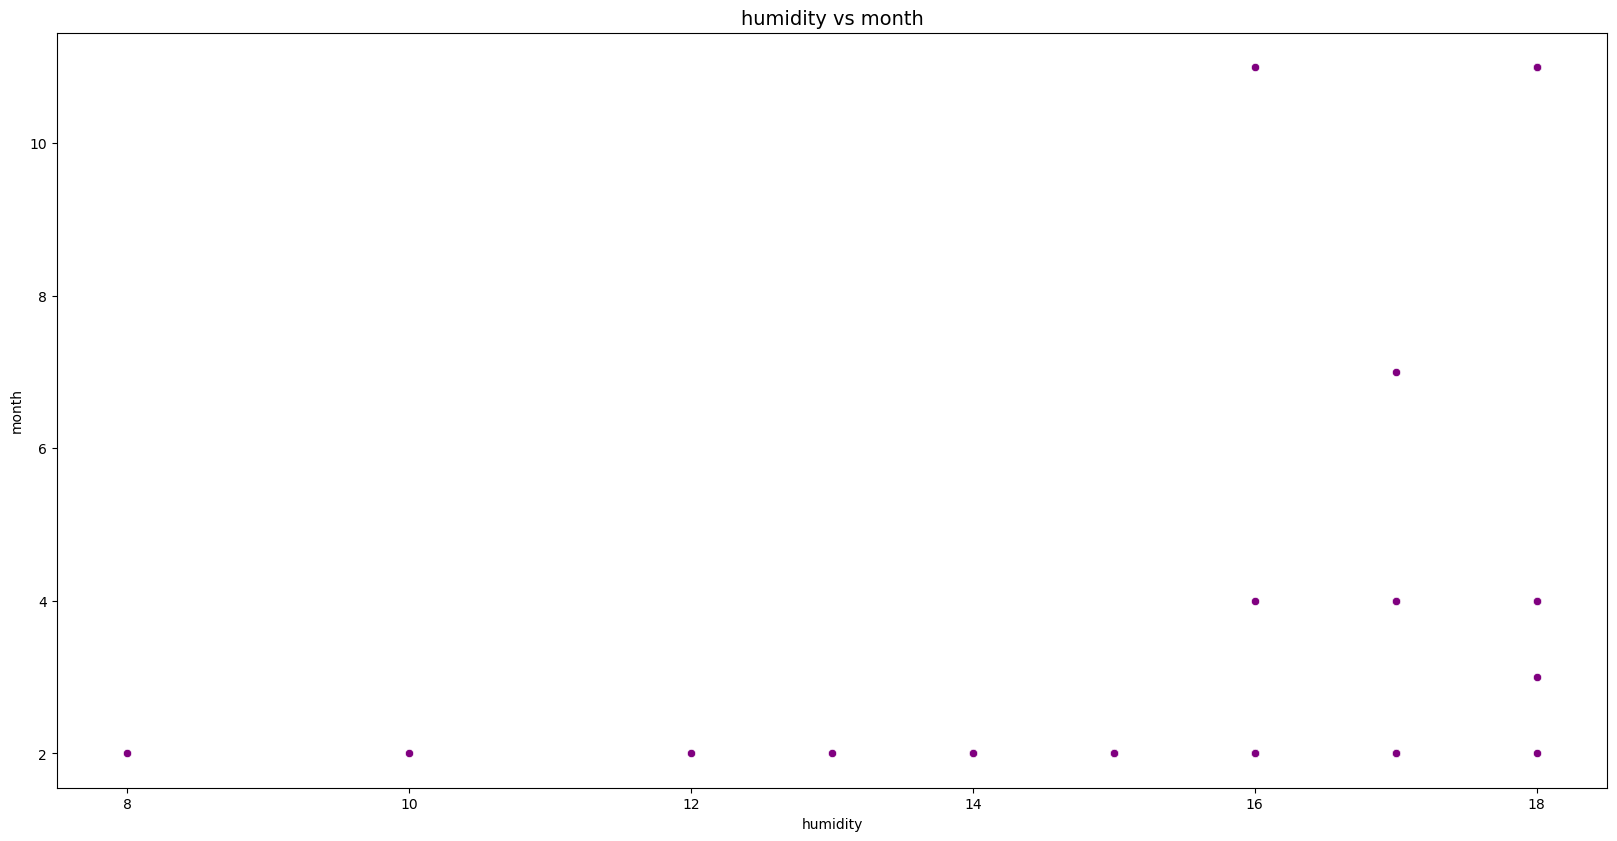

In [64]:
plt.figure(figsize=(20,10),dpi=100)
sns.scatterplot(data = df[df['humidity']<=18],x='humidity',y='month', color="purple")
plt.title(f'humidity vs month', fontsize=14)
plt.show()

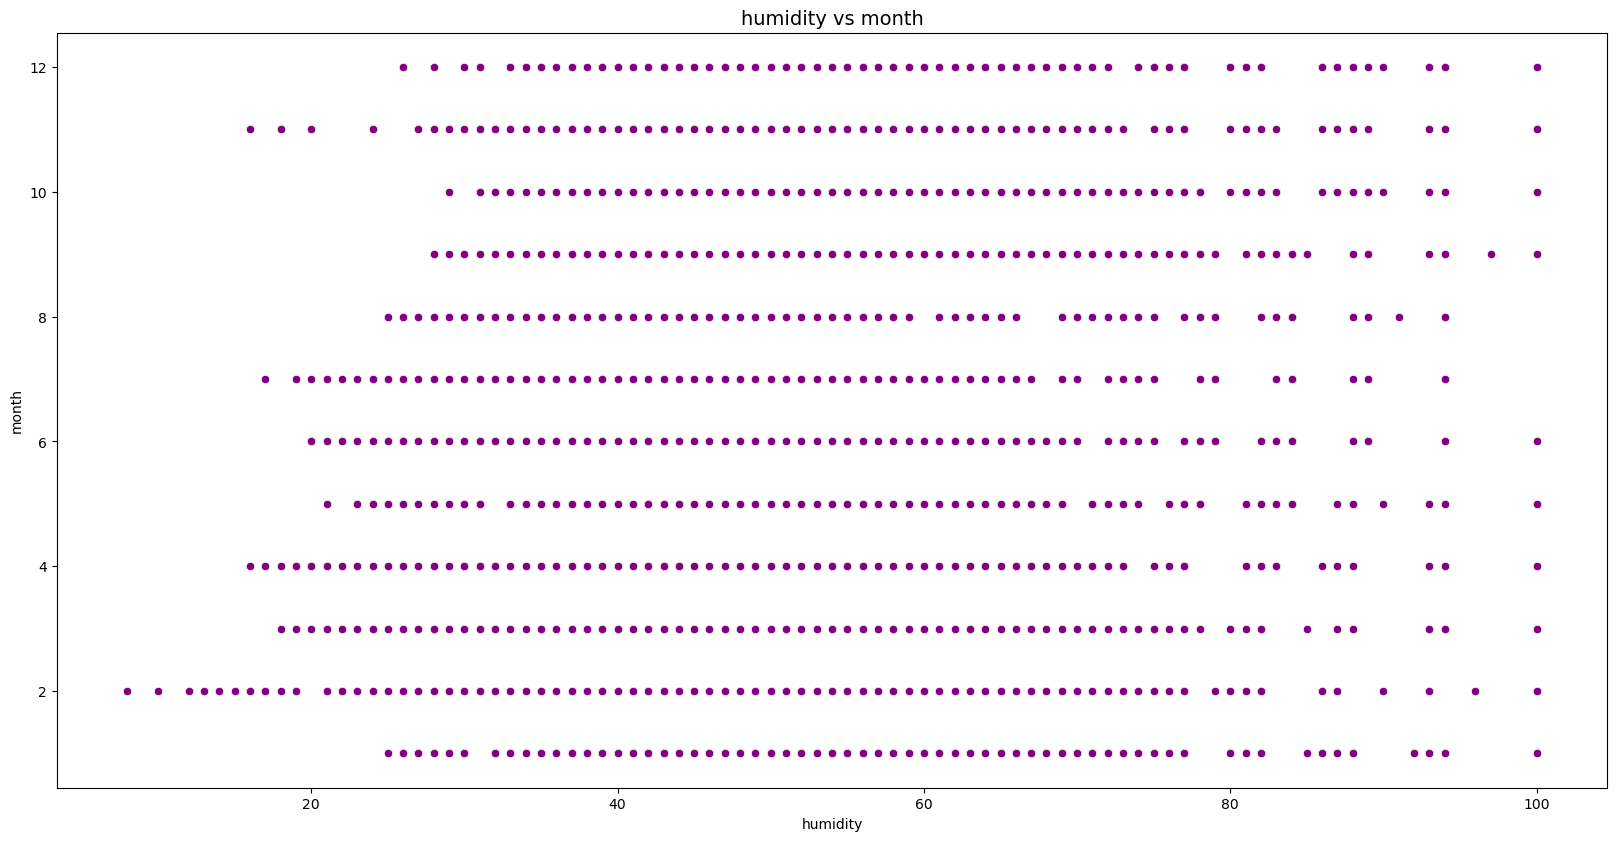

In [65]:
plt.figure(figsize=(20,10),dpi=100)
sns.scatterplot(data = df,x='humidity',y='month', color="purple")
plt.title(f'humidity vs month', fontsize=14)
plt.show()

Low humidity points seem to be mostly on February and in night hours. For now we will not treat them differently and assume a linear behavour of humidity.

### What about categorical feature weather?

In [16]:
df.groupby('weather').mean()['count']

weather
1    4.673980
2    4.545450
3    4.050533
4    5.105945
Name: count, dtype: float64

In [17]:
df['weather'].value_counts()

1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64

There is only one weather 4. Including it to weather 3

In [18]:
df['weather'] = df['weather'].replace(4, 3)
df['weather'][df['weather']==4] = 3

/var/folders/c4/jkw5wy1d7lndc6p4y832vmrc0000gn/T/ipykernel_68735/2408207529.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weather'][df['weather']==4] = 3


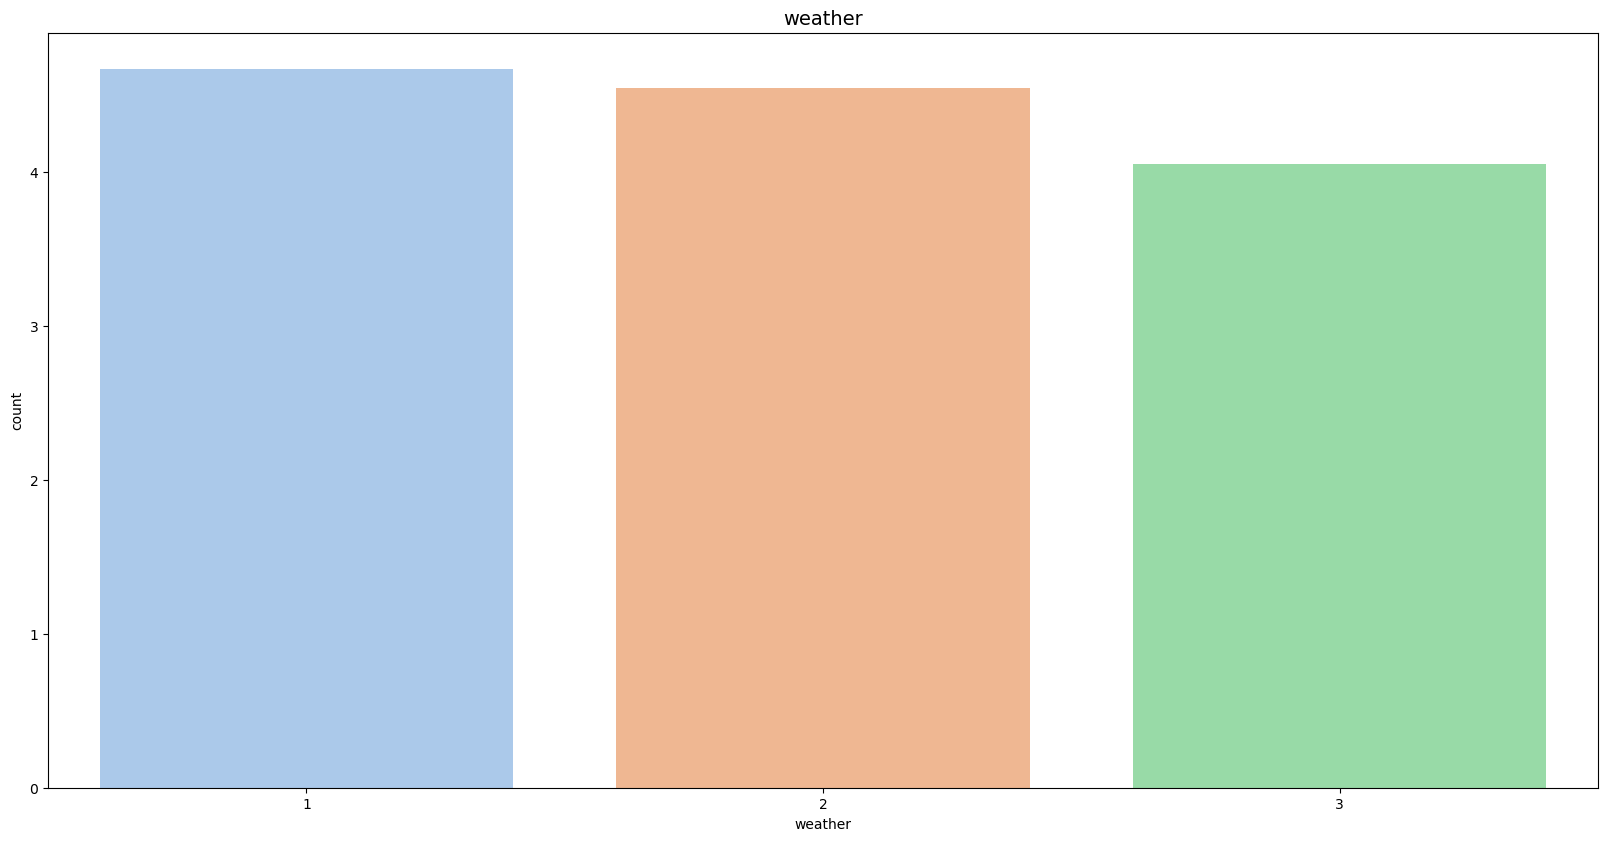

In [19]:
plt.figure(figsize=(20,10),dpi=100)
sns.barplot(data =df.groupby('weather').mean(), x = df.groupby('weather').mean().index, y ='count', palette='pastel', )
#sns.scatterplot(data = ,x='weather',y='count')
plt.title(f'weather', fontsize=14)
plt.show()

### Conclusions
* Mean counts reduce when weather conditions are bad.

## Check correlation between categorical features

In [20]:
# Cramers V: suggested correlation between categorical features
import scipy.stats as ss
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

Text(0.5, 1.0, 'Pairwise Correlation')

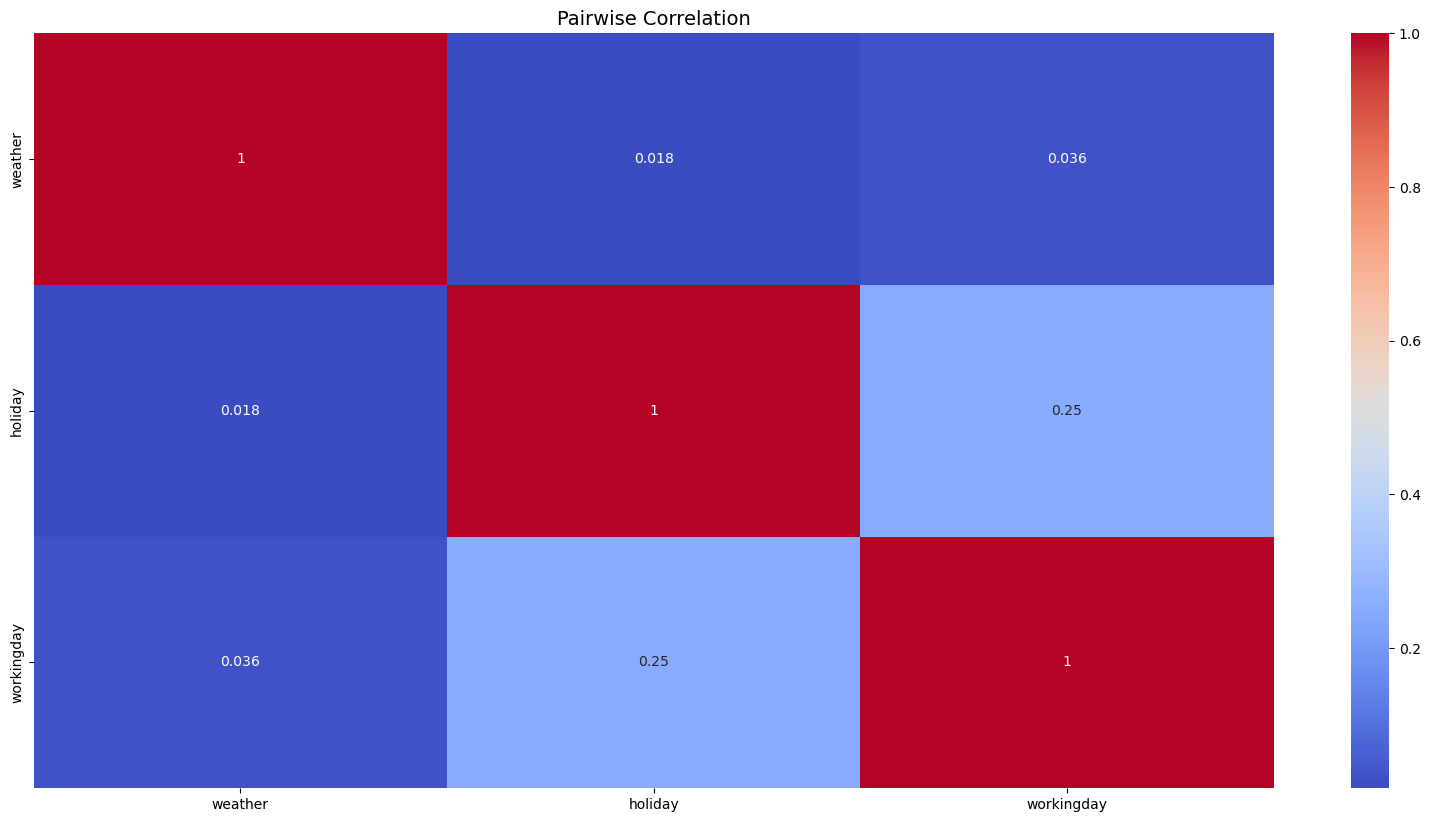

In [21]:
plt.figure(figsize=(20,10),dpi=100)
sns.heatmap(df[['weather','holiday', 'workingday']].corr(cramers_v),cmap='coolwarm',annot=True)
plt.title('Pairwise Correlation', fontsize=14)

In [22]:
# Correlation ratio: suggested correlation between categorical-numerical features
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

Text(0.5, 1.0, 'Pairwise Correlation')

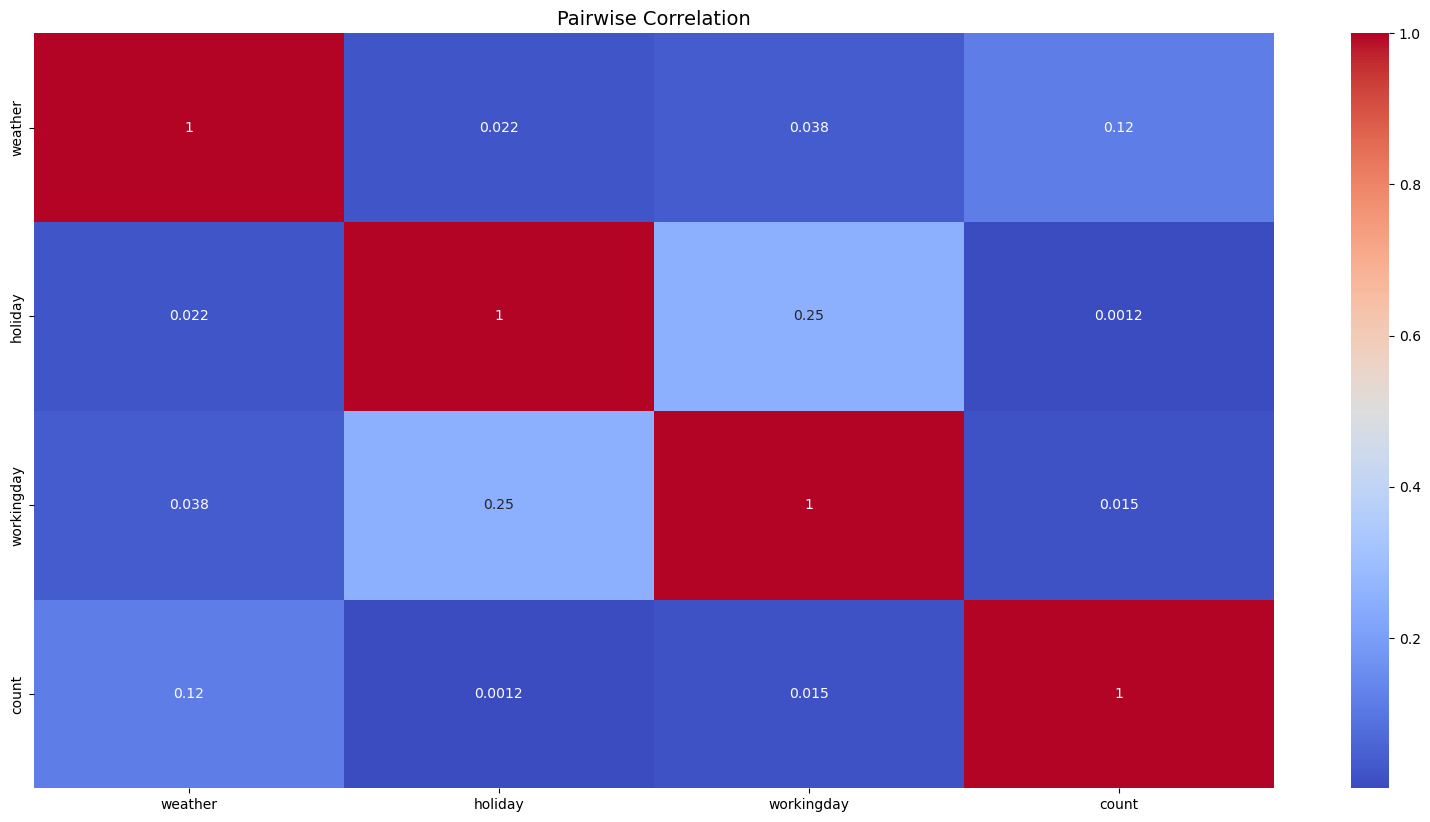

In [23]:
plt.figure(figsize=(20,10),dpi=100)
sns.heatmap(df[['weather', 'holiday', 'workingday','count']].corr(correlation_ratio),cmap='coolwarm',annot=True)
plt.title('Pairwise Correlation', fontsize=14)

## How does time affect counts

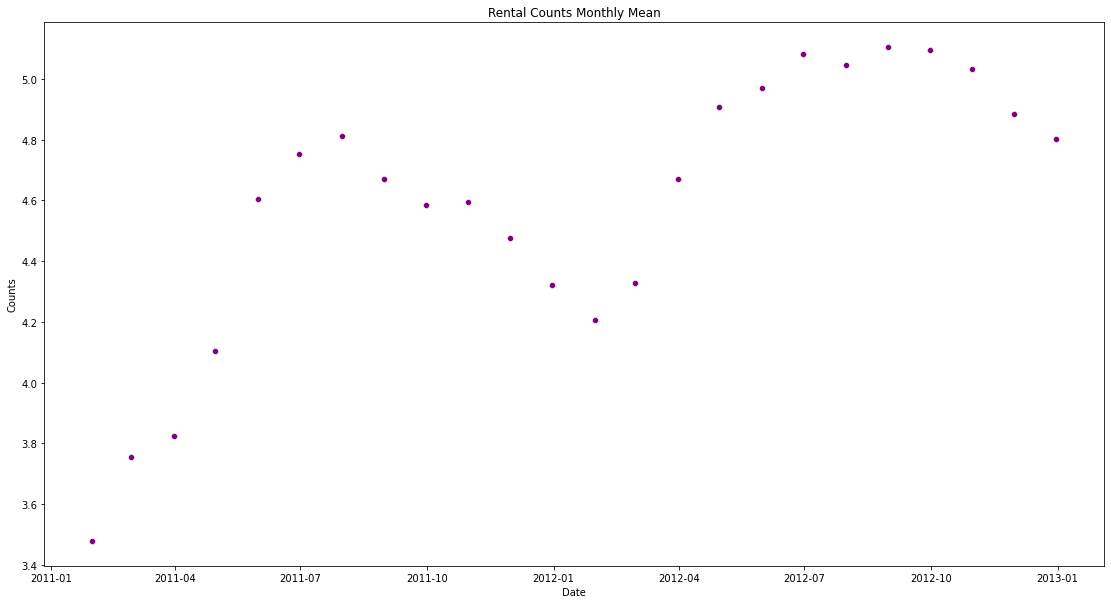

In [24]:
# monthy average over time
plt.figure(figsize=(19,10))
sns.scatterplot(data =df.resample('M').mean(), x = 'datetime', y ='count', color='purple')
plt.ylabel('Counts')
plt.xlabel('Date')
plt.title('Rental Counts Monthly Mean')
plt.show()

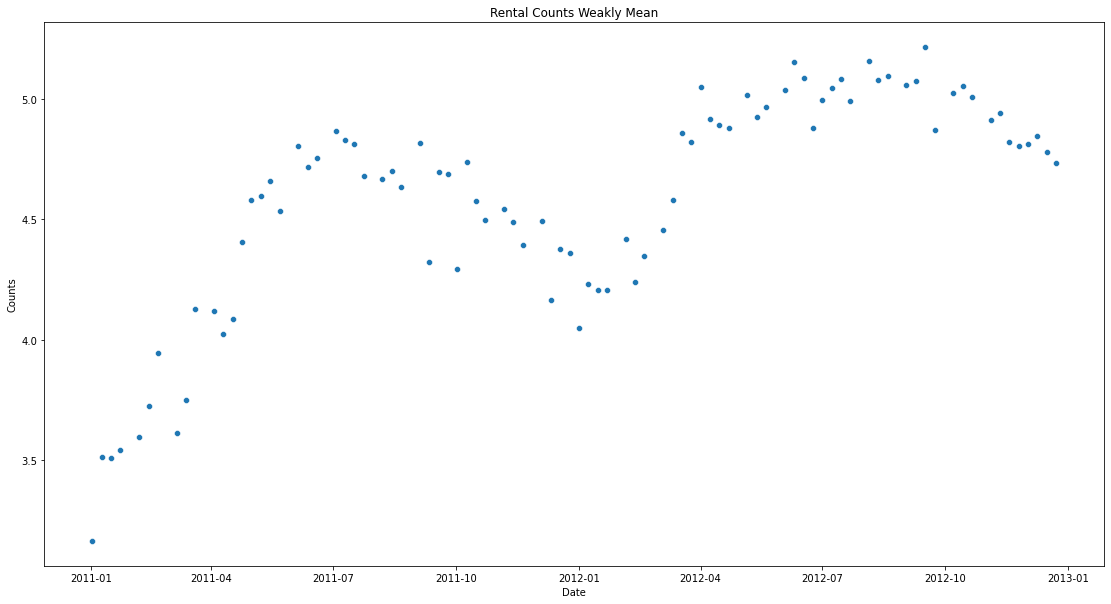

In [25]:
# Weakly average over time
plt.figure(figsize=(19,10))
sns.scatterplot(data =df.resample('W').mean(), x = 'datetime', y ='count')
plt.ylabel('Counts')
plt.xlabel('Date')
plt.title('Rental Counts Weakly Mean')
plt.show()

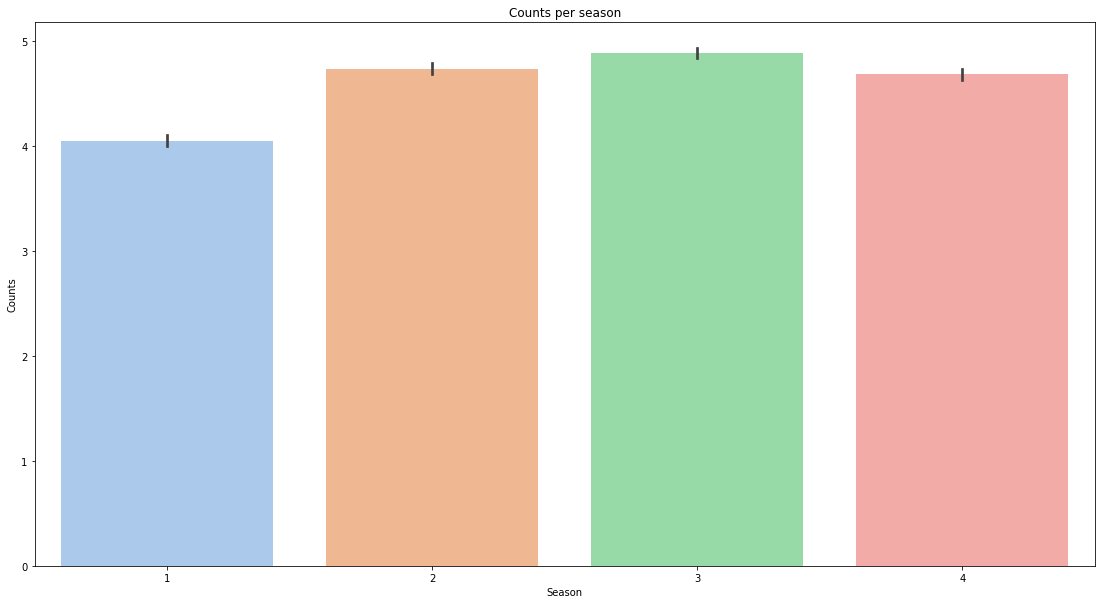

In [26]:
# season average
plt.figure(figsize=(19,10))
sns.barplot(data =df, x = 'season', y ='count', palette='pastel', ) 
plt.xlabel('Season')
plt.ylabel('Counts')
plt.title('Counts per season')
plt.show()

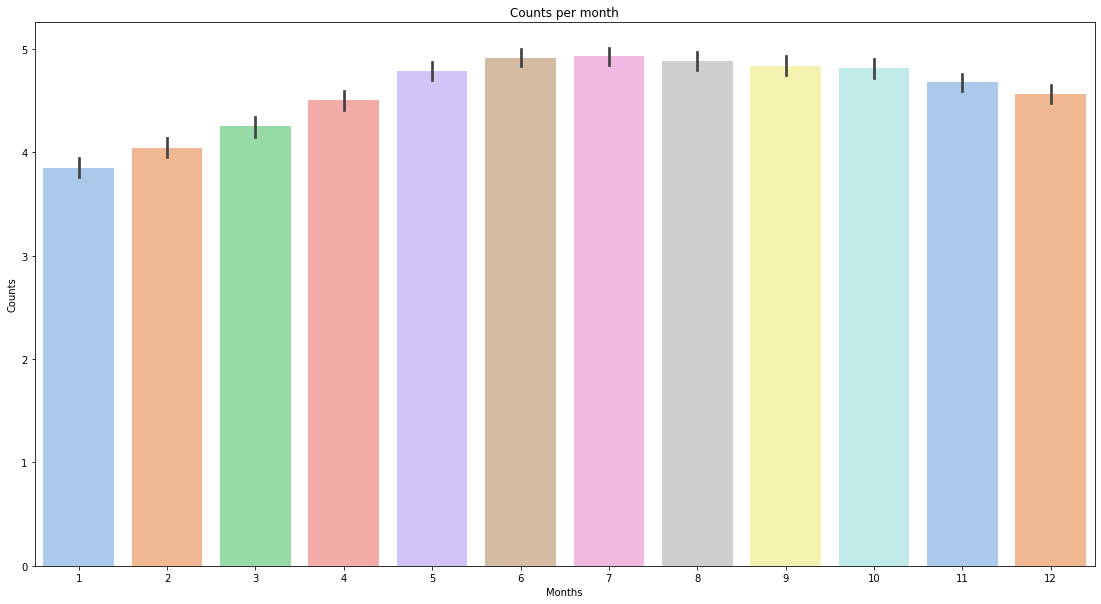

In [27]:
# monthy average
plt.figure(figsize=(19,10))
sns.barplot(data =df, x = 'month', y ='count', palette='pastel', ) 
plt.xlabel('Months')
plt.ylabel('Counts')
plt.title('Counts per month')
plt.show()

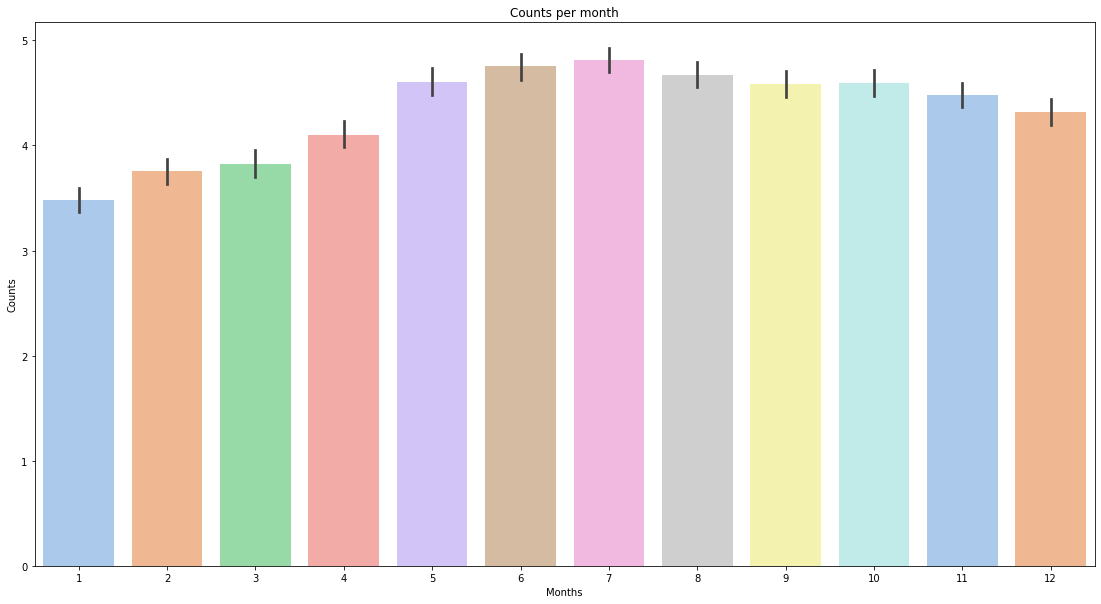

In [28]:
plt.figure(figsize=(19,10))
sns.barplot(data =df[df['year']==2011], x = 'month', y ='count', palette='pastel', ) 
plt.xlabel('Months')
plt.ylabel('Counts')
plt.title('Counts per month')
plt.show()

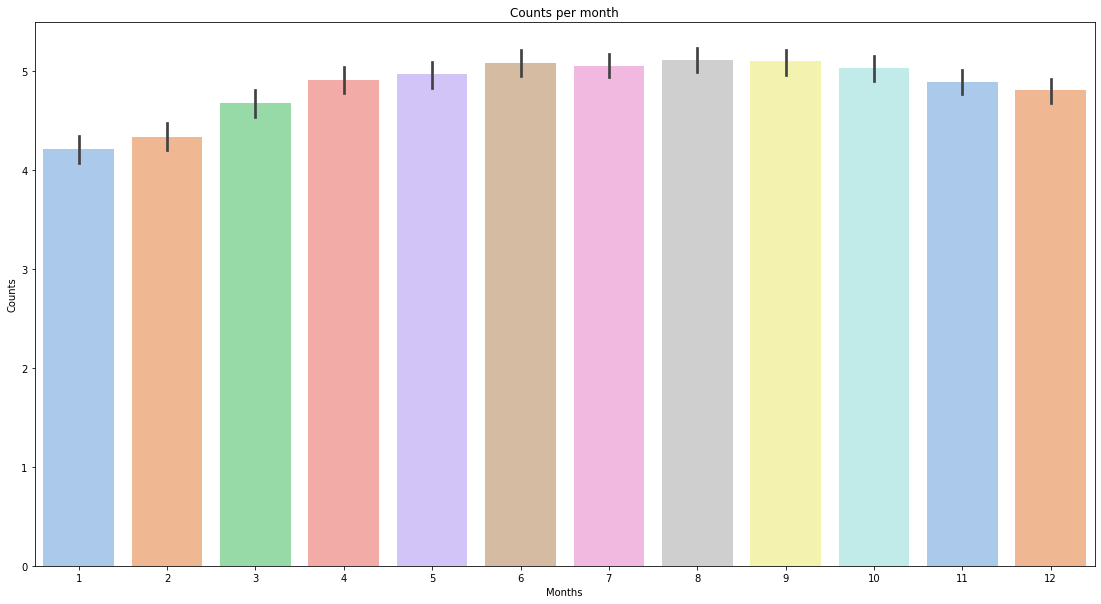

In [29]:
plt.figure(figsize=(19,10))
sns.barplot(data =df[df['year']==2012], x = 'month', y ='count', palette='pastel', ) 
plt.xlabel('Months')
plt.ylabel('Counts')
plt.title('Counts per month')
plt.show()

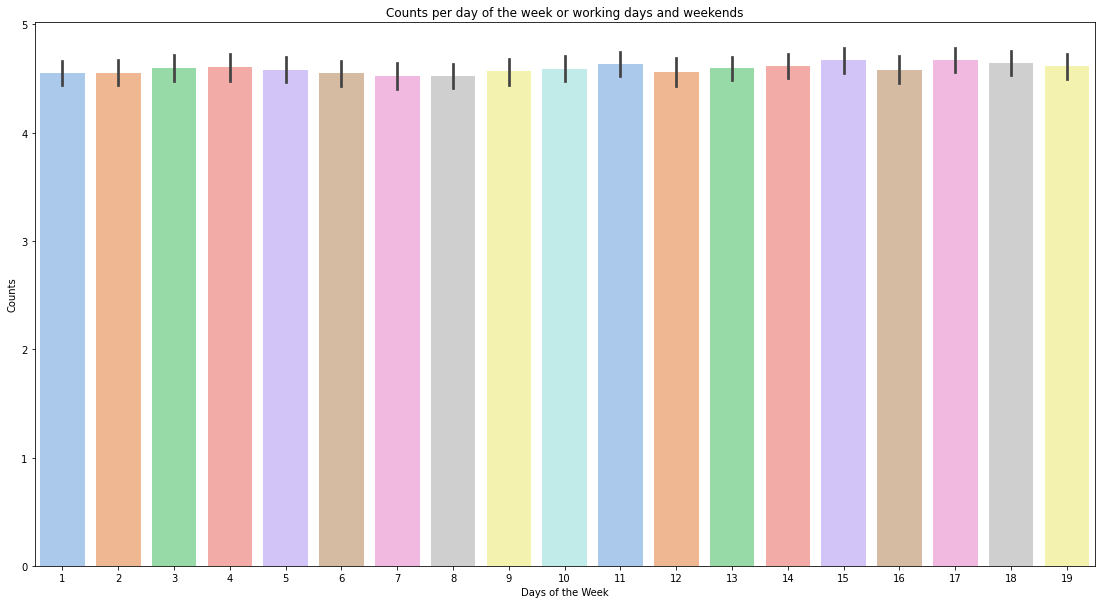

In [30]:
plt.figure(figsize=(19,10))
sns.barplot(data =df, x = 'day', y ='count', palette='pastel', ) 
plt.xlabel('Days of the Week')
plt.ylabel('Counts')
plt.title('Counts per day of the week or working days and weekends')
plt.show()

* We see a clear yearly periodicity and a up going trend
* Data do not contain the last days of the month. For the days we have information, there seems to not be a trend. 

In [31]:
# create column to count months past to capture treand and yearly periodicity
df['month_count'] = df['month']+(df['year']-2011)*12

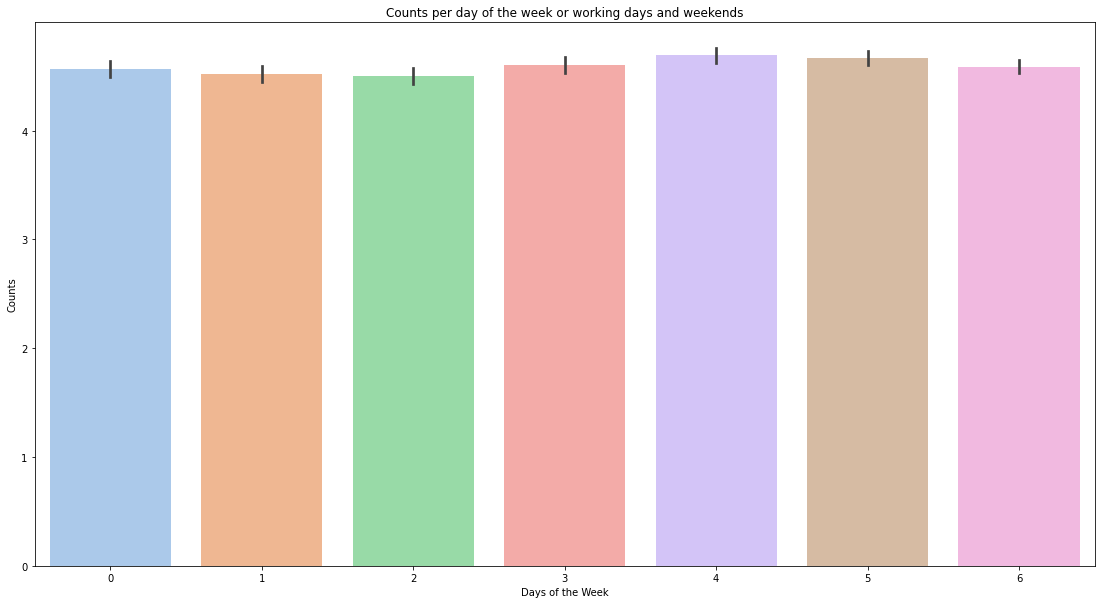

In [32]:
plt.figure(figsize=(19,10))
sns.barplot(data =df, x = 'weekday', y ='count', palette='pastel') 
plt.xlabel('Days of the Week')
plt.ylabel('Counts')
plt.title('Counts per day of the week or working days and weekends')
plt.show()

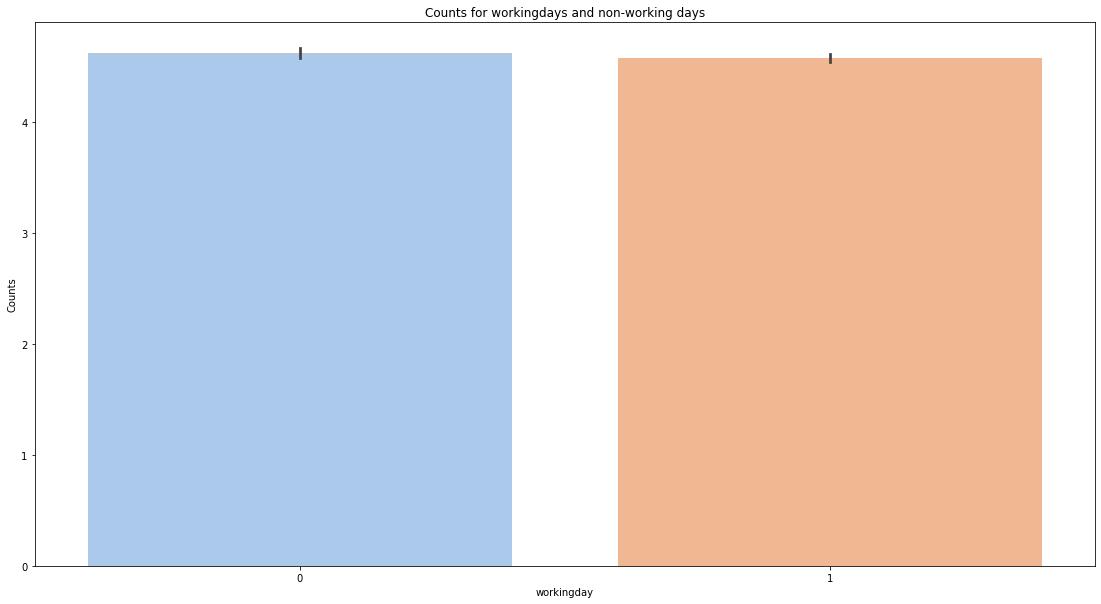

In [33]:
plt.figure(figsize=(19,10))
sns.barplot(data =df, x = 'workingday', y ='count', palette='pastel') 
plt.xlabel('workingday')
plt.ylabel('Counts')
plt.title('Counts for workingdays and non-working days')
plt.show()

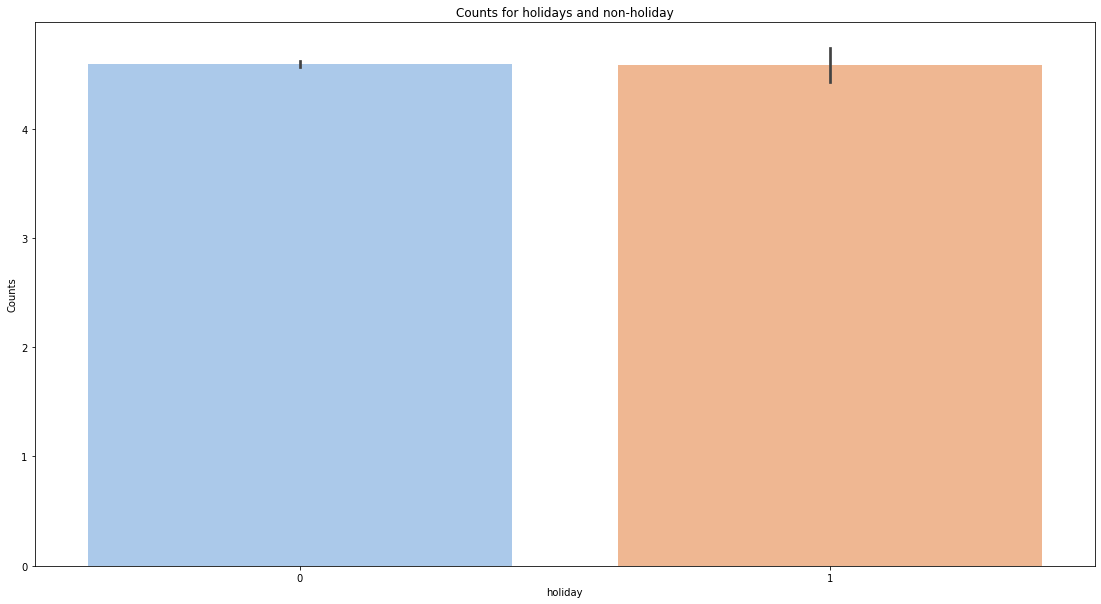

In [34]:
plt.figure(figsize=(19,10))
sns.barplot(data =df, x = 'holiday', y ='count', palette='pastel') 
plt.xlabel('holiday')
plt.ylabel('Counts')
plt.title('Counts for holidays and non-holiday')
plt.show()

* The day of the week does not seem to affect significantly the total count, with a possible exception on Sunday, where counts are slightly reduced.   

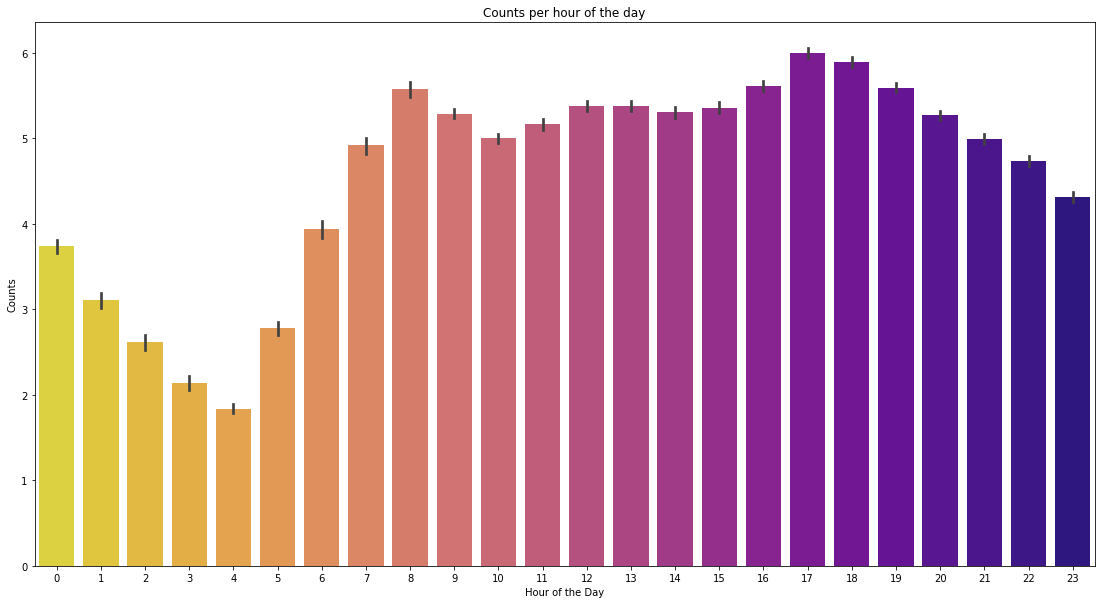

In [35]:
plt.figure(figsize=(19,10))
sns.barplot(data =df, x = 'hour', y ='count',  palette='plasma_r', )
plt.xlabel('Hour of the Day')
plt.ylabel('Counts')
plt.title('Counts per hour of the day')
plt.show()

We have now cheacked how each column affects seperatly.

'season': Shows how counts behaviour with seasons. But months are much better for this. Thus we drop it.

'holiday'-'workingday': Separation to working days and non-working days seems enough. We drop holiday.

'weather': Shows clear correlation with counts. Keep.

'temp' Shows clear correlation with counts but also 98% with 'atemp'. Drop

'atemp': If we drop 'temp', keep.

'humidity': Inverse correlated to counts. Keep.

'windspeed': The correlation is not very clear. Drop. 

'hour': Clear correlation with counts and periodicity. Keep 

'day': No significant change on mean counts through out the different days. Drop.

'weekday': Shows some small drop on counts on Sundays. Keep. 

'month'-'year': Show a strong trend and periodicity. Keep.

## Diagrams representing interaction between features

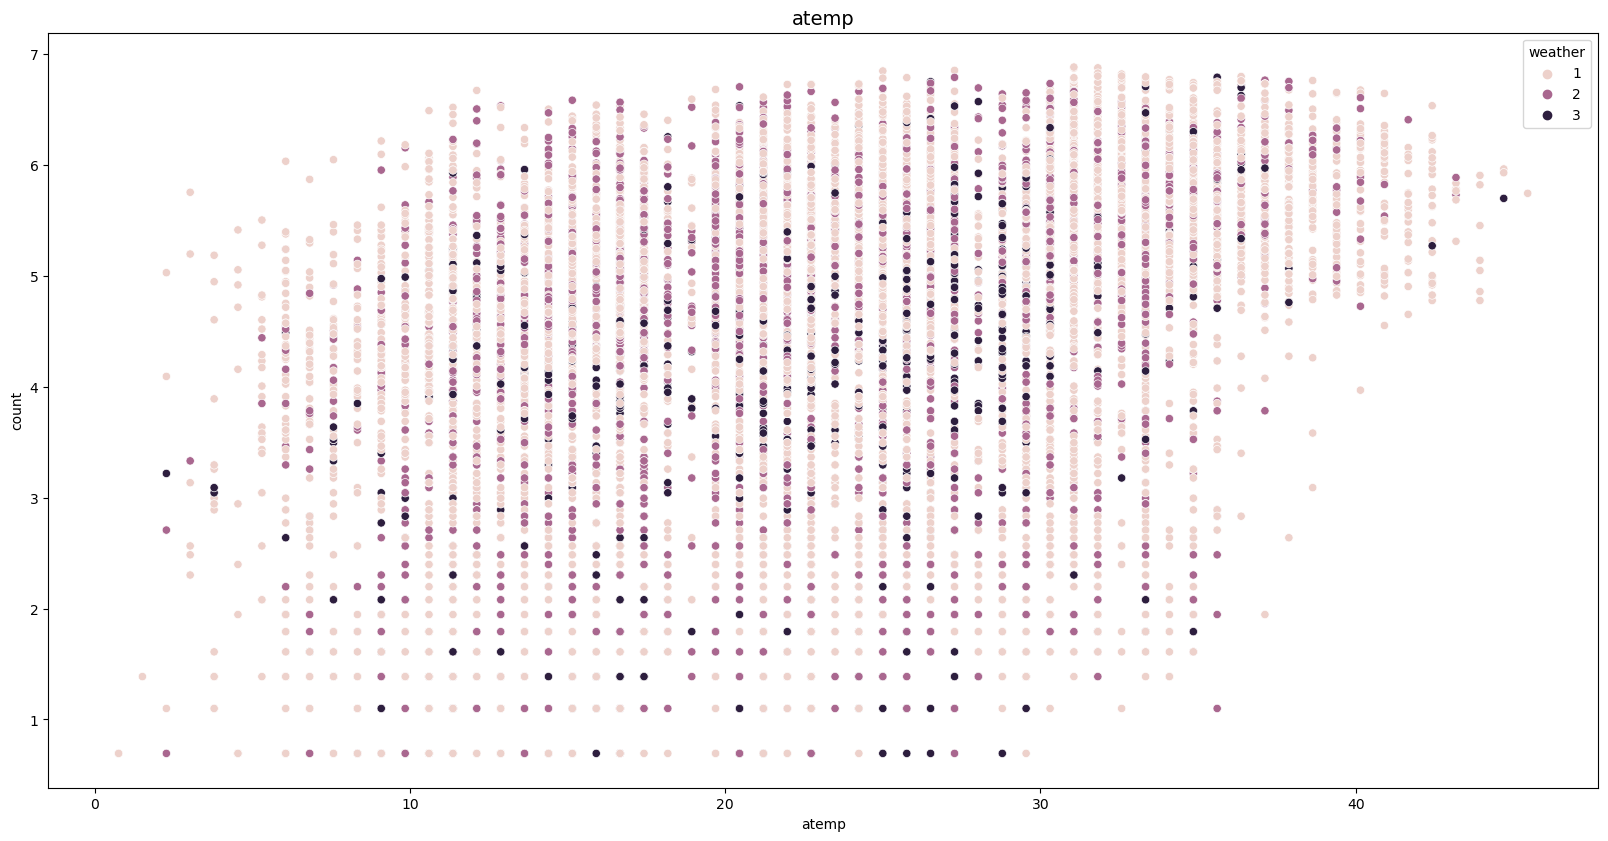

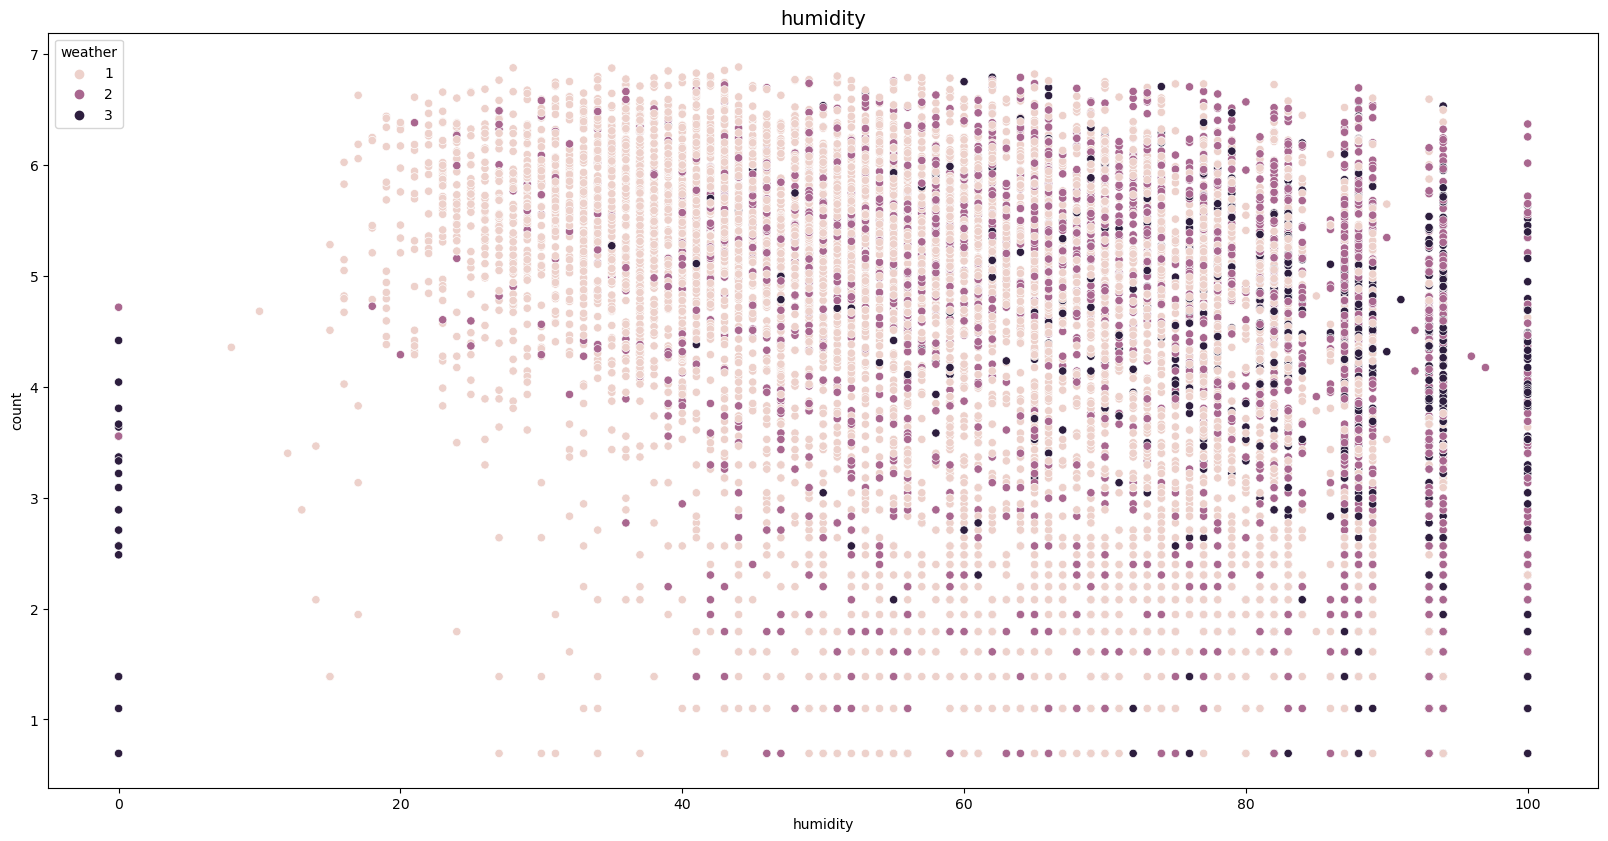

In [36]:
for column in ['atemp', 'humidity']:
    plt.figure(figsize=(20,10),dpi=100)
    sns.scatterplot(data = df,x=column,y='count', hue='weather', color="purple")
    plt.title(f'{column}', fontsize=14)
    plt.show()

It seems like the zeros in humidity are 100%.

In [37]:
df['humidity'][df['humidity']<=0.001]=100

/var/folders/c4/jkw5wy1d7lndc6p4y832vmrc0000gn/T/ipykernel_68735/701435664.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['humidity'][df['humidity']<=0.001]=100


In [38]:
df[['humidity']].describe()

,humidity
count,10886.000000
mean,62.088554
std,19.118725
min,8.000000
25%,47.000000
50%,62.000000
75%,78.000000
max,100.000000


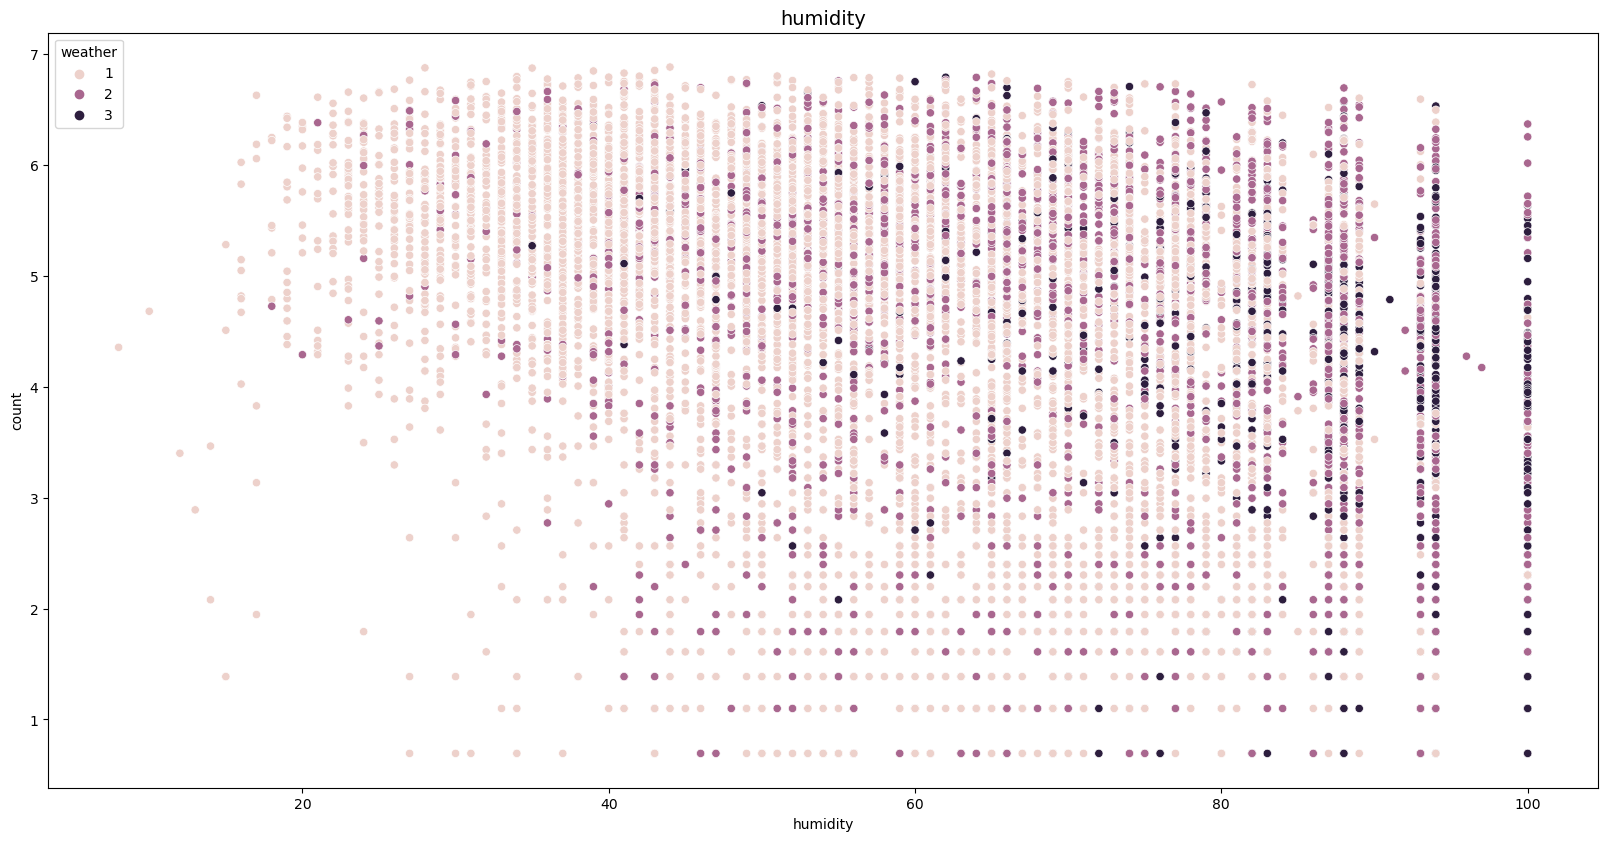

In [39]:
for column in ['humidity']:
    plt.figure(figsize=(20,10),dpi=100)
    sns.scatterplot(data = df,x=column,y='count', hue='weather', color="purple")
    plt.title(f'{column}', fontsize=14)
    plt.show()

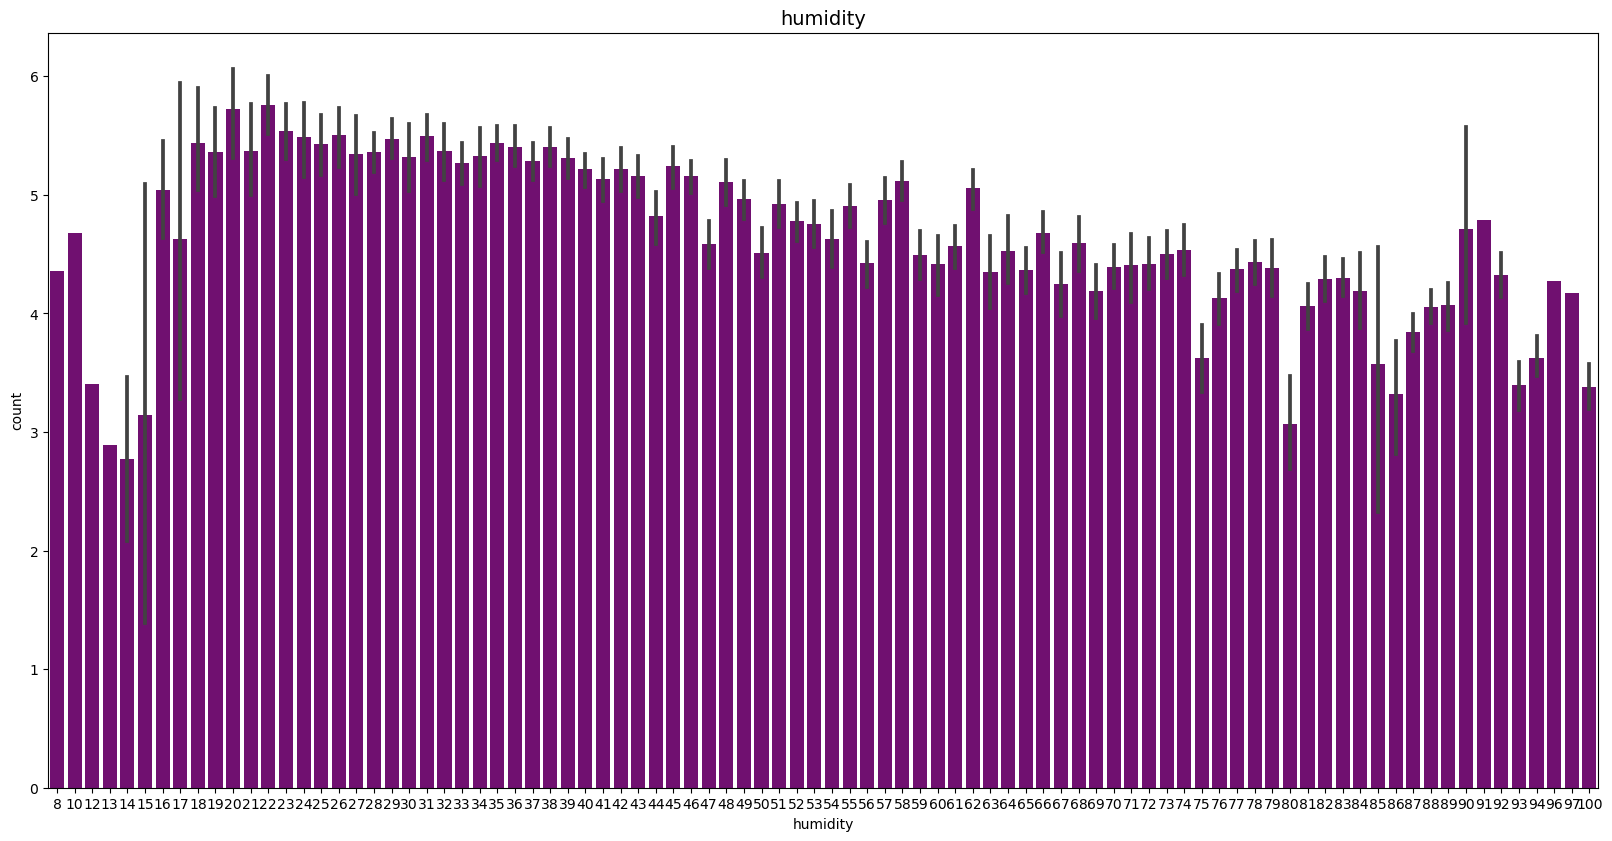

In [53]:
for column in ['humidity']:
    plt.figure(figsize=(20,10),dpi=100)
    sns.barplot(data = df,x=column,y='count', color="purple")
    plt.title(f'{column}', fontsize=14)
    plt.show()

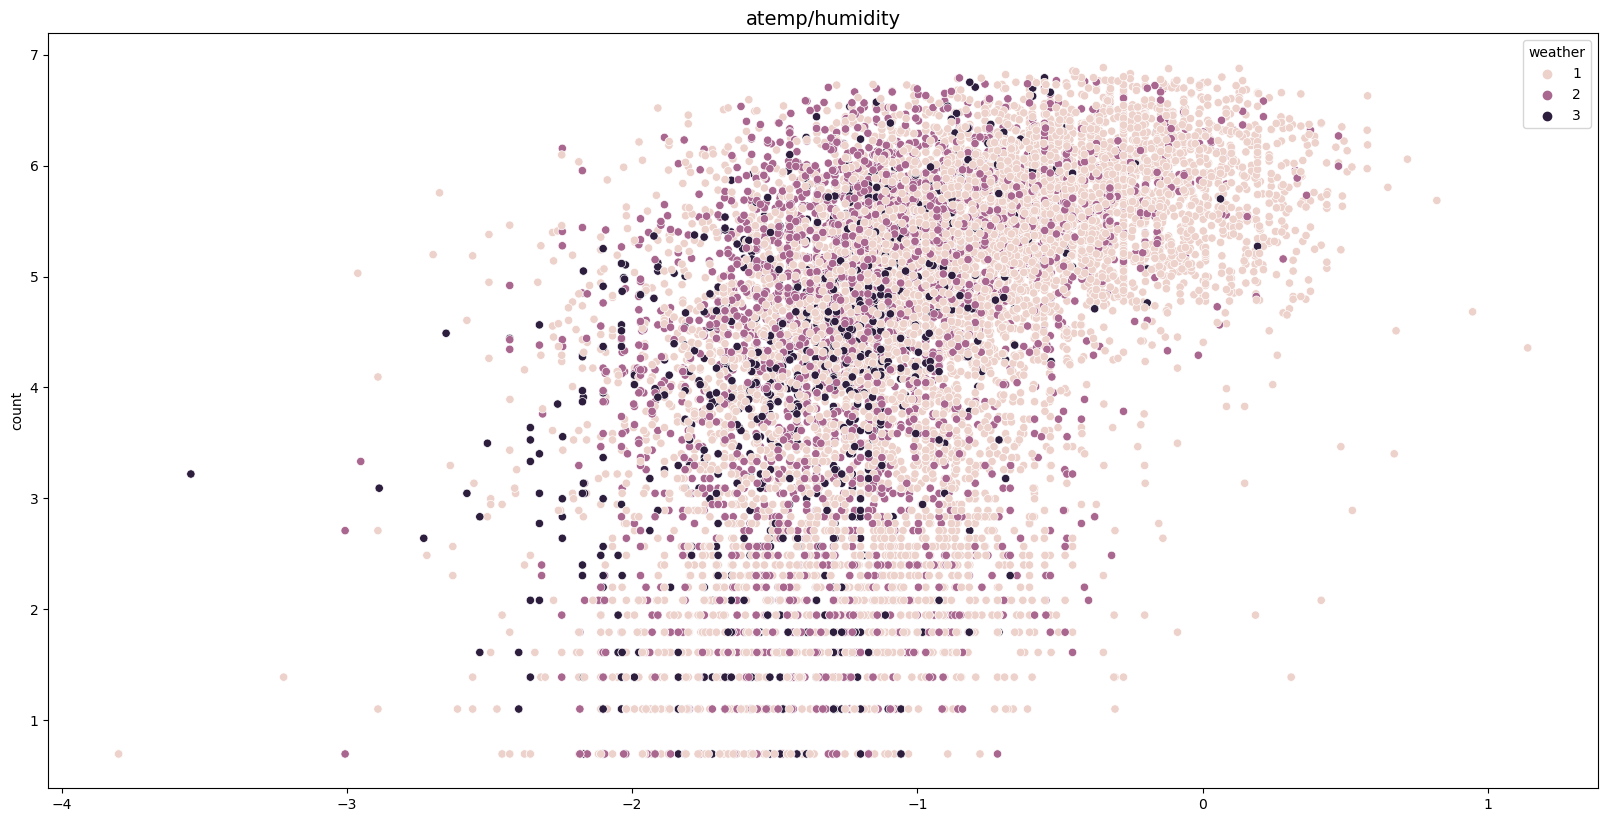

In [41]:
product = np.log(df['atemp']/df['humidity'])
plt.figure(figsize=(20,10),dpi=100)
sns.scatterplot(data = df,x=product,y='count', hue='weather', color="purple")
plt.title(f'atemp/humidity', fontsize=14)
plt.show()

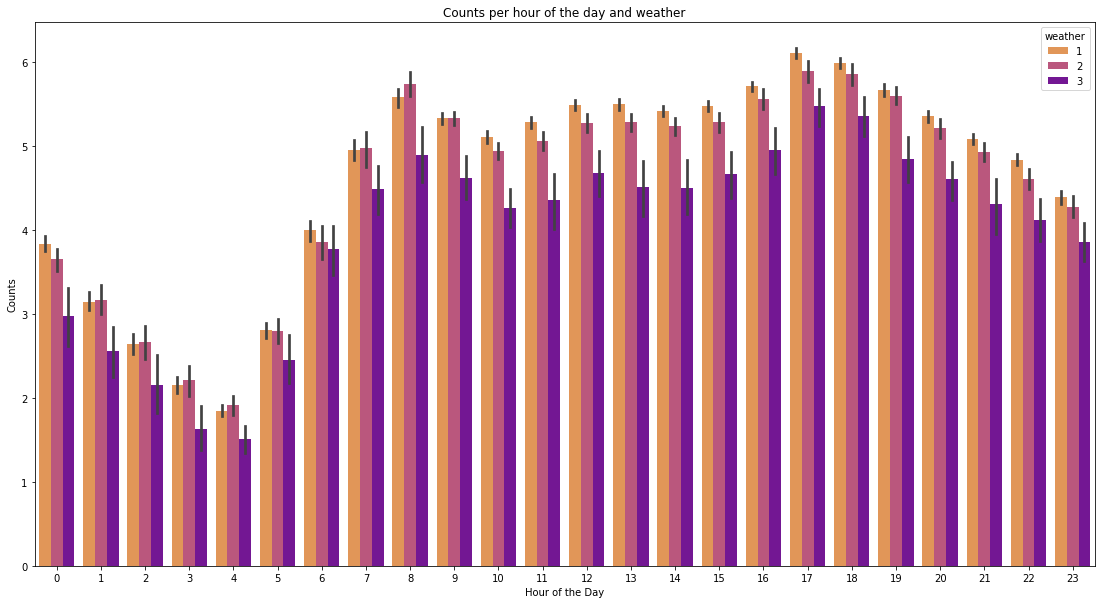

In [42]:
plt.figure(figsize=(19,10))
sns.barplot(data =df, x = 'hour', y ='count', hue = 'weather', palette='plasma_r', )
plt.xlabel('Hour of the Day')
plt.ylabel('Counts')
plt.title('Counts per hour of the day and weather')
plt.show()

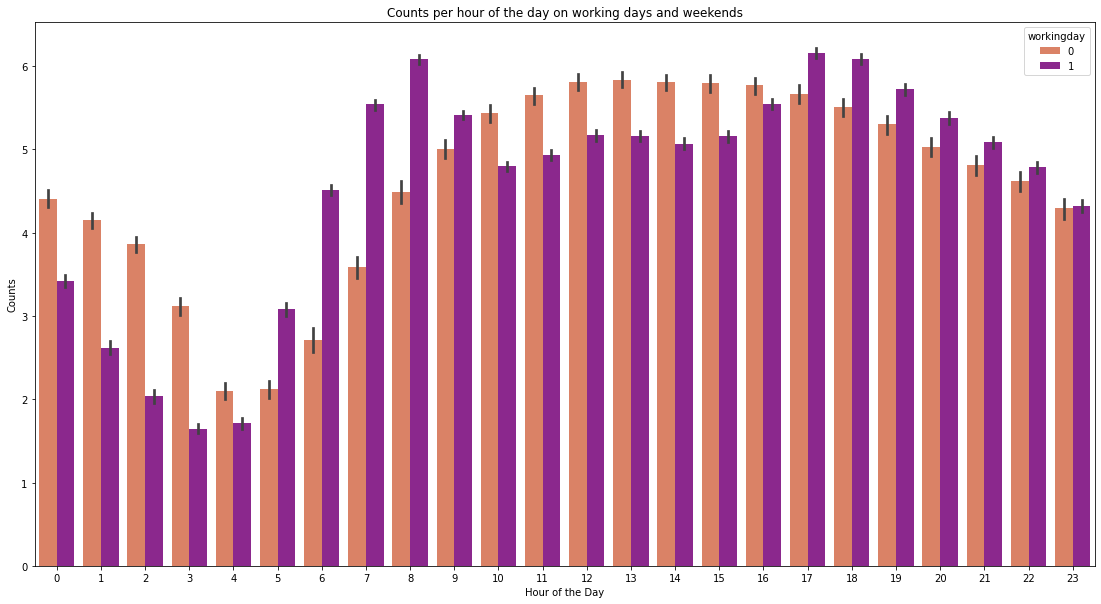

In [43]:
plt.figure(figsize=(19,10))
sns.barplot(data =df, x = 'hour', y ='count', hue = 'workingday', palette='plasma_r', )
plt.xlabel('Hour of the Day')
plt.ylabel('Counts')
plt.title('Counts per hour of the day on working days and weekends')
plt.show()

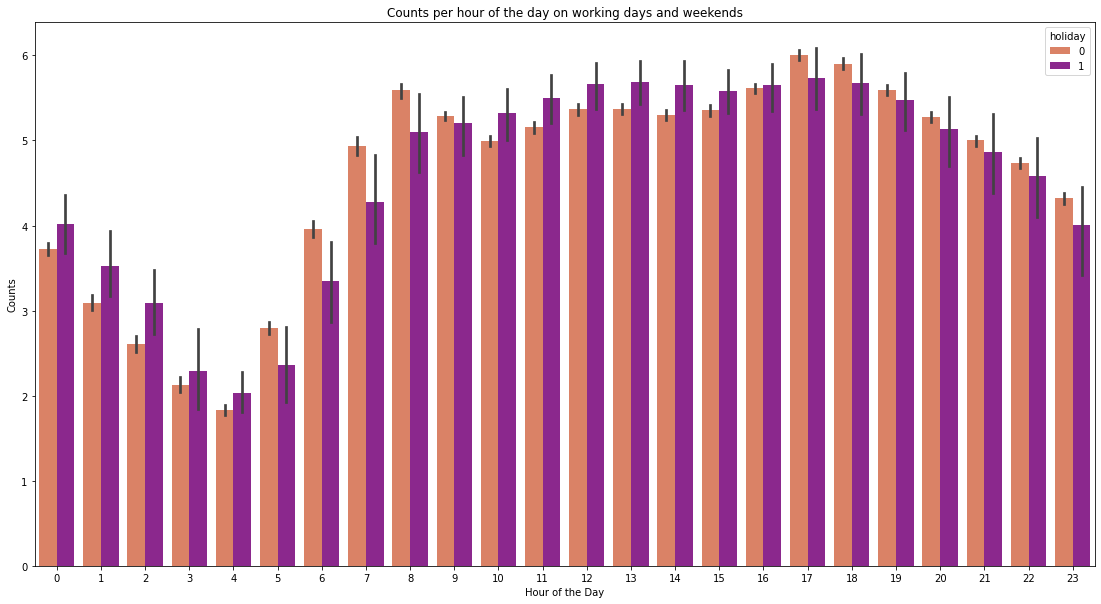

In [44]:
plt.figure(figsize=(19,10))
sns.barplot(data =df, x = 'hour', y ='count', hue = 'holiday', palette='plasma_r', )
plt.xlabel('Hour of the Day')
plt.ylabel('Counts')
plt.title('Counts per hour of the day on working days and weekends')
plt.show()

* The hourly behavour changes singificantly between working days and non-working days.  
* Working days, there are picks on 8h and 17h and a fast drop towards the minimum 3-4h, while for non-working days there is a plato between 12h and 16h and then droping slower to the minimum, which now is around 4-5h. 

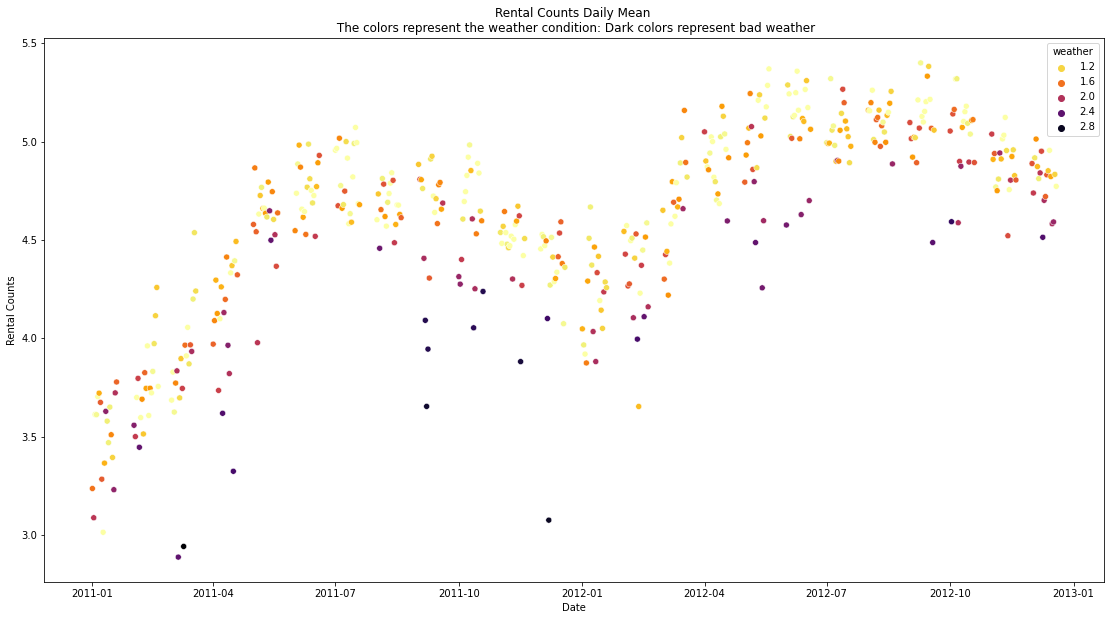

In [45]:
plt.figure(figsize=(19,10))
sns.scatterplot(data =df.resample('D').mean(), x = 'datetime', y ='count',hue='weather',palette="inferno_r")
plt.ylabel('Rental Counts')
plt.xlabel('Date')
plt.title('Rental Counts Daily Mean \n The colors represent the weather condition: Dark colors represent bad weather')
plt.show()

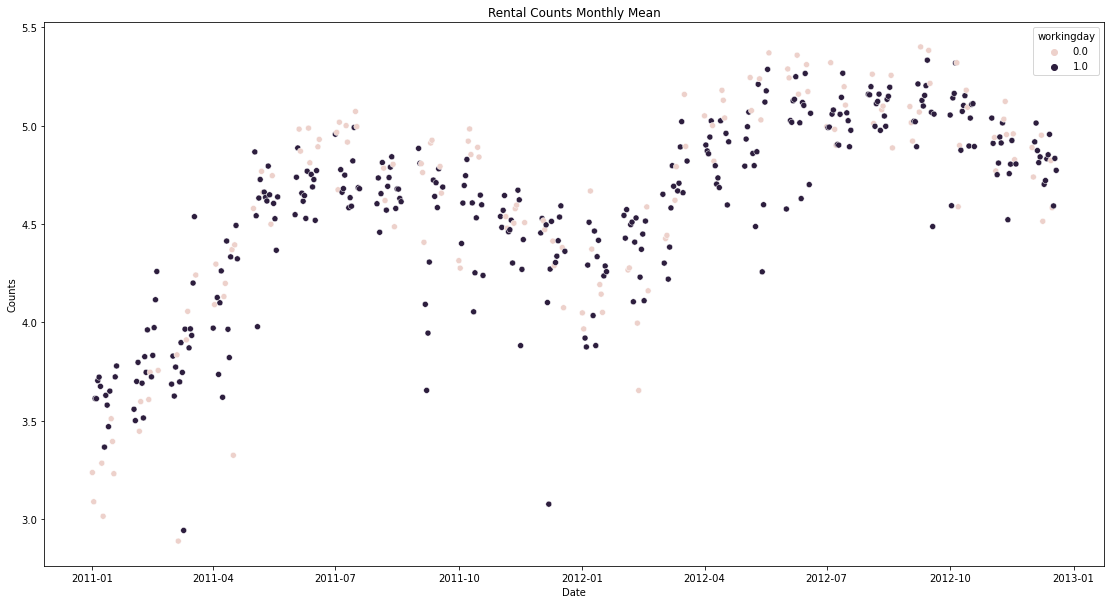

In [46]:
plt.figure(figsize=(19,10))
sns.scatterplot(data =df.resample('D').mean(), x = 'datetime', y ='count',hue='workingday')
plt.ylabel('Counts')
plt.xlabel('Date')
plt.title('Rental Counts Monthly Mean')
plt.show()

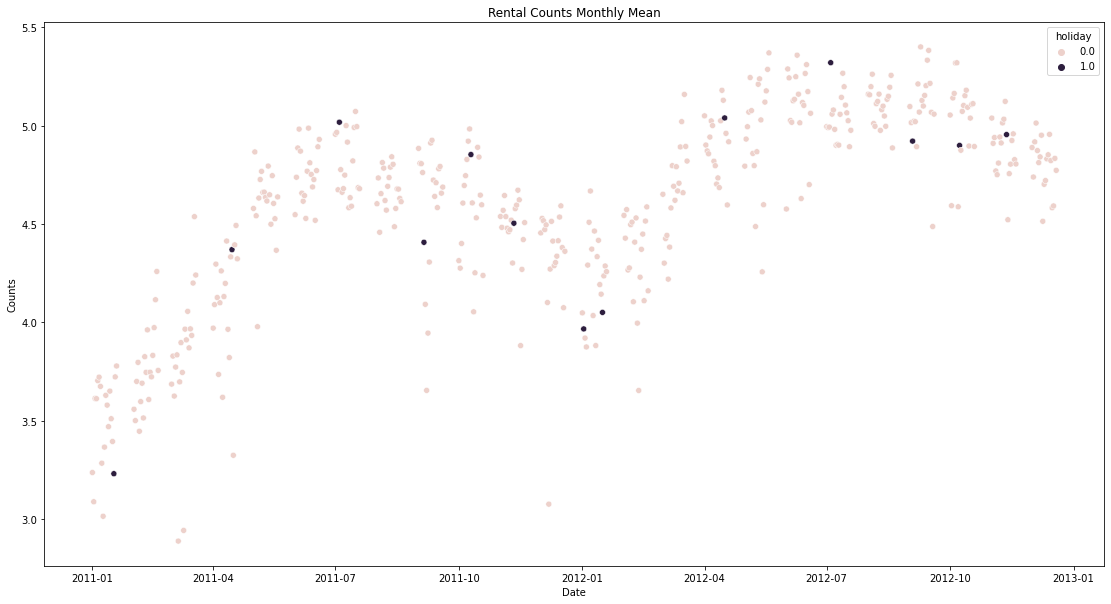

In [47]:
plt.figure(figsize=(19,10))
sns.scatterplot(data =df.resample('D').mean(), x = 'datetime', y ='count',hue='holiday')
plt.ylabel('Counts')
plt.xlabel('Date')
plt.title('Rental Counts Monthly Mean')
plt.show()

## Feature engineering

In [48]:
y = df['count']
X = df.drop(columns=[ 'casual', 'registered', 'count'])

In [49]:
X.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'hour', 'day', 'weekday', 'month', 'year',
       'month_count'],
      dtype='object')

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42) 